# Hateful memes baseline
This notebook aims to establish a baseline we will be using for experiments. It will contain the following unimodally pretained components:
- BERT for text classification
- CLIP for visual embeddings

For the classification head, it will use default head of BERTforSequenceClassication, which comprises of two linear layers.


## Step 0: Loading the data and importing libraries

### Loading libraries


In [62]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
#import cv2
import numpy as np
import pandas as pd
import os

In [63]:
from torch.utils.data import DataLoader
try:
    from transformers import AdamW
except:
    !pip install transformers
    from transformers import AdamW

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm, notebook

### Loading Data

Next we need to connect to the storage. The script assumes the following folder structure:
```
.
|-hateful_memes
  |-dev_seen.jsonl
  |-train_jsonl
  |-img
    |-{all memes}
  [-embeds
    |-{all embeds}
```

So basically just make sure you have the unzipped hateful memes folder in the current working directory. Feel free to change this part to something that works with your environment

The data is available on my google drive for those who want to download the embedding directly or look at folder structure:

https://drive.google.com/drive/folders/19KGR-NA-XzdDaAlHcKcwCqatDxpS4W5s?usp=sharing

If the embeddings are downloaded, after finishing step 0 you can skip directly to step 3

In [64]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [65]:
#navigate to correct folder
#%cd 'gdrive/MyDrive/OMSCS/CS7643/Project'
#!ls

In [66]:
ENVIRONMENT = 'gcp'  # gcp, colab, or local
if ENVIRONMENT == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/deep-learning-project/roberta_text_classifier'
    data_path = '../data'
elif ENVIRONMENT == 'gcp':
    #!pip install torchtext
    data_path = 'gs://hateful_memes/hateful_memes'
    data_path_alt = 'https://storage.cloud.google.com/hateful_memes/hateful_memes'
else:
    data_path = '../data'

In [67]:
train = pd.read_json(path_or_buf=f"{data_path}/train.jsonl", lines=True)
val = pd.read_json(path_or_buf=f"{data_path}/dev_seen.jsonl", lines=True)
test = pd.read_json(path_or_buf=f"{data_path}/test_seen.jsonl", lines=True)

In [68]:
# visualing the train set
train

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [69]:
# Connect to bucket
from google.cloud import storage
#from os import environ
#environ['GOOGLE_APPLICATION_CREDENTIALS']='./credentials.json'
client = storage.Client(project='deep-learning-project-347210')
bucket = client.get_bucket('hateful_memes')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


https://storage.cloud.google.com/hateful_memes/hateful_memes/img/42953.png
meme_text1: its their character not their color that matters
meme_label1: 0
(400, 265, 3)


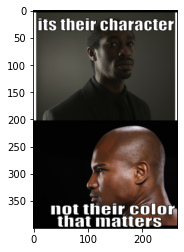

In [70]:
#visualizing the image
idx = 0
meme_text1 = train['text'][idx]
meme_label1 = train['label'][idx]
#img1 = plt.imread(f"hateful_memes/{train['img'][idx]}")
img_path = train['img'][idx]
print(f"{data_path_alt}/{img_path}")

# Download image from bucket
image_blob = bucket.get_blob(f'hateful_memes/{img_path}')
local_image = img_path.split('/')[1]
image_blob.download_to_filename(local_image)

#img1 = plt.imread(f"{data_path_alt}/{img_path}")
img1 = plt.imread(local_image)
print(f"meme_text1: {meme_text1}")
print(f"meme_label1: {meme_label1}")
print(img1.shape)
plt.imshow(img1)

os.remove(local_image)

In [71]:
#TEXT_MODEL = "bert-base-uncased"
#TEXT_MODEL = 'xlm-roberta-base'
#TEXT_MODEL = 'roberta-large-mnli'
#TEXT_MODEL = 'roberta-base'
TEXT_MODEL = 'ernie-2.0-en'

from torch.utils.data import Dataset

if TEXT_MODEL == "bert-base-uncased":
    # bert-base-uncased
    from transformers import BertTokenizerFast, BertForSequenceClassification, BertModel
    #from transformers import BertTokenizer, BertForSequenceClassification, BertModel
    tokenizer = BertTokenizerFast.from_pretrained(TEXT_MODEL)
    #tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL)
    text_embed_model = BertModel.from_pretrained(TEXT_MODEL)

elif TEXT_MODEL in ['roberta-base', 'roberta-large-mnli']:
    # roberta-base
    from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel#, RobertaConfig
    tokenizer = RobertaTokenizer.from_pretrained(TEXT_MODEL)
    text_embed_model = RobertaModel.from_pretrained(TEXT_MODEL)
    
elif TEXT_MODEL in ['xlm-roberta-base', 'xlm-roberta-large', 'xlm-roberta-large-finetuned-conll03-english']:
    # xlm-roberta-base
    #from transformers import XLMTokenizer, XLMForSequenceClassification, XLMModel#, XLMConfig
    #tokenizer = XLMTokenizer.from_pretrained(TEXT_MODEL)
    #text_embed_model = XLMModel.from_pretrained(TEXT_MODEL)
    
    from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
    tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
    text_embed_model = AutoModel.from_pretrained(TEXT_MODEL)
    
elif TEXT_MODEL == 'ernie-2.0-en':
    # nghuyong/ernie-2.0-en
    # Source: https://huggingface.co/nghuyong/ernie-2.0-en
    from transformers import AutoTokenizer, AutoModel
    tokenizer = AutoTokenizer.from_pretrained(f'nghuyong/{TEXT_MODEL}')
    text_embed_model = AutoModel.from_pretrained(f'nghuyong/{TEXT_MODEL}')
    
else:
    raise Exception('TEXT_MODEL must be one of: bert-based-uncased, roberta-base, xlm-roberta-base, nghuyong/ernie-2.0-en')
    

from transformers import CLIPFeatureExtractor, CLIPVisionModel
from transformers import Trainer, TrainingArguments
from PIL import Image


#creating a pytorch dataset format
class HMdataset(Dataset):
  def __init__(self,dataframe, tokenizer, img_tfm, text_only = False):
    #tokenized representation of text
    self.text = dataframe['text']
    self.text_tokens = tokenizer(dataframe['text'].to_list(),padding = True)
    self.labels = torch.tensor(dataframe['label'])
    self.img = dataframe['img']
    self.img_tfm = img_tfm
    self.text_only = text_only

  def __getitem__(self,idx):
    item = {}
    item['text'] = self.text[idx]
    item['text_tokens'] = torch.tensor(self.text_tokens['input_ids'][idx])
    item['attention_mask'] = torch.tensor(self.text_tokens['attention_mask'][idx])
    item['labels'] = self.labels[idx]
    if not self.text_only:
        image_blob = bucket.get_blob(f'hateful_memes/{self.img[idx]}')
        local_image = self.img[idx].split('/')[1]
        image_blob.download_to_filename(local_image)
        item['img'] = self.img_tfm(Image.open(local_image).convert('RGB'))
        os.remove(local_image)
        #item['img'] = self.img_tfm(Image.open(f"{data_path_alt}/{self.img[idx]}").convert('RGB'))
    return item
  def __len__(self):
    return len(self.labels)

Some weights of the model checkpoint at nghuyong/ernie-2.0-en were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [72]:
#creating tokens
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#converting image to same size
clip_ftm = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')
img_tfm = lambda im: clip_ftm(images=im, return_tensors='pt', do_center_crop=False)['pixel_values'][0]

# #creating dataset with these encodings and img transformation
train_dataset = HMdataset(train, tokenizer, img_tfm)
val_dataset = HMdataset(val, tokenizer, img_tfm)
test_dataset = HMdataset(test, tokenizer, img_tfm)

In [73]:
# creating dataloader
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= False)

#sanity checks
item = next(iter(train_dataloader))

display(item['img'][0].shape)
display(item['text'][0])
display(item['text_tokens'][0])
display(item['attention_mask'][0])

torch.Size([3, 224, 224])

'its their character not their color that matters'

tensor([ 101, 2049, 2037, 2839, 2025, 2037, 3609, 2008, 5609,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


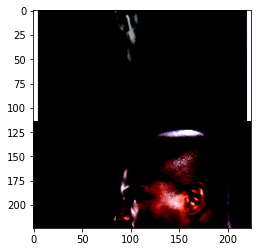

In [74]:
plt.imshow(item['img'][0].swapaxes(0,2).swapaxes(0,1))

## Step 1: Creating text embeddings

In [75]:
#will use the dataset but with text only set to True, this will speed up read/write since we are only dealing with text at the time
train_dataset = HMdataset(train, tokenizer,img_tfm, text_only = True)
val_dataset = HMdataset(val, tokenizer,img_tfm, text_only = True)
test_dataset = HMdataset(test, tokenizer,img_tfm, text_only = True)

IMPORTANT: Choose the intended model here:

In [76]:
# create embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

text_embed_model.to(device)

#have data loaders ready
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

#function to generate embeddings given a model and a data loader. Also returns label incase shuffle is set to true
def generate_text_embeddings(loader, embed_model):
  embed = []
  with torch.no_grad():
      #progress_bar = tqdm_notebook(loader, unit = 'batch')
      progress_bar = notebook.tqdm(loader, unit = 'batch')
      batch_no = 1
      for batch in progress_bar:
        
        input_ids = batch['text_tokens'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = embed_model(input_ids, attention_mask = attention_mask, output_hidden_states = True)

        #populate embeddings and move them back to cpu
        embed.append(outputs['last_hidden_state'].to(torch.device('cpu')))

        #upadate progress bar
        progress_bar.set_description_str(f"Batch: {batch_no}")
        batch_no +=1

        #emtpy catche
        torch.cuda.empty_cache()

        
  
  #concatenate data across all batches
  embeds = torch.cat(embed,dim = 0)

  return embeds




In [77]:
# see if embeddings are saved, otherwise generate embeddings
import os

if os.path.exists(f"embeds/{TEXT_MODEL}_train_embeds.pt"):
  print("embedding already exists")
else:
  print("generating embeddings")
  train_text_embeds = generate_text_embeddings(train_loader, text_embed_model)
  val_text_embeds = generate_text_embeddings(val_loader, text_embed_model)
  test_text_embeds = generate_text_embeddings(test_loader, text_embed_model)

  #sanity checks
  display(train_text_embeds.shape) #see shape of (dataset length, sequence_length, dimension)
  display(val_text_embeds.shape) #see shape of (dataset length, sequence_length, dimension)
  display(test_text_embeds.shape) #see shape of (dataset length, sequence_length, dimension)

  #create embeds folder and then store to disk to save time
  try:
    import os
    os.mkdir("embeds")
  except:
    pass

  #store tensor to disk
  try:
      torch.save(train_text_embeds,f"embeds/{TEXT_MODEL}_train_embeds.pt")
      torch.save(val_text_embeds,f"embeds/{TEXT_MODEL}_val_embeds.pt")
      torch.save(test_text_embeds,f"embeds/{TEXT_MODEL}_test_embeds.pt")
  except:
      TEXT_MODE_NAME = TEXT_MODEL.split('/')[1]  # remove creator name directory e.g. john/modelA --> modelA
      torch.save(train_text_embeds, f'embeds/{TEXT_MODEL}_train_embeds.pt')
      torch.save(val_text_embeds, f'embeds/{TEXT_MODEL}_val_embeds.pt')
      torch.save(test_text_embeds, f'embeds/{TEXT_MODEL}_test_embeds.pt')
        
  # delete embeddings to save ram
  del train_text_embeds
  del val_text_embeds
  del test_text_embeds


embedding already exists


## Step 2: Creating Visual Embeddings

In [78]:
from transformers import CLIPVisionModel

vision_model_name = 'openai/clip-vit-base-patch32'
vision_embed_model = CLIPVisionModel.from_pretrained(vision_model_name)


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.10.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.bias', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'visual_projection.weight', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.4.layer_norm1.weight', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.out_proj.weight', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.10.self_attn.v_proj.weight', 'text_model.final_layer_norm.bias', 'text_model.encoder.layers.2.self_attn.out_proj.bias', 'text_model.encoder.layers.8.mlp.fc1.bias', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.laye

In [79]:
#will use the dataset wuth the images
train_dataset = HMdataset(train, tokenizer,img_tfm, text_only = False)
val_dataset = HMdataset(val, tokenizer,img_tfm, text_only = False)
test_dataset = HMdataset(test, tokenizer,img_tfm, text_only = False)



In [80]:
# create embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vision_embed_model.to(device)

#have data loaders ready
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

#function to generate embeddings given a model and a data loader. Also returns label incase shuffle is set to true
# returns:
# 1) embeds: embedding from the last hidden layer
# 2) labels: labels for each embedding of 0 or 1
# 3) hidden states: list of hidden states. -1 is the last hidden layer
def generate_vision_embeddings(loader, vision_embed_model):
  embed = []
  with torch.no_grad():
      #create progress bar
      #progress_bar = tqdm_notebook(loader, unit = 'batch')
      progress_bar = notebook.tqdm(loader, unit='batch')
      batch_no = 1

      #run batchwise embedding generation
      for batch in progress_bar:
        imgs = batch['img'].to(device)
        labels = batch['labels'].to(device)

        outputs = vision_embed_model(imgs, output_hidden_states = True)

        #populate embeddings
        embed.append(outputs['last_hidden_state'].to(torch.device('cpu')))

        #upadate progress bar
        progress_bar.set_description_str(f"Batch: {batch_no}")
        batch_no +=1

        #emtpy catche
        torch.cuda.empty_cache()
    
  embeds = torch.cat(embed,dim = 0)

  return embeds


In [81]:
vision_model_save_name = "clip-vit-base-patch32"

if os.path.exists(f"embeds/{vision_model_save_name}_train_embeds.pt"):
  print("embedding already exists")
else:
  print("generating embeddings")
  train_vision_embeds = generate_vision_embeddings(train_loader,vision_embed_model)
  val_vision_embeds = generate_vision_embeddings(val_loader,vision_embed_model)
  test_vision_embeds = generate_vision_embeddings(test_loader,vision_embed_model)

  #show dimension
  train_vision_embeds.shape # shape of size (set size, sequence_len, dimension)

  #store tensor to disk
  torch.save(train_vision_embeds,f"embeds/{vision_model_save_name}_train_embeds.pt")
  torch.save(val_vision_embeds,f"embeds/{vision_model_save_name}_val_embeds.pt")
  torch.save(test_vision_embeds,f"embeds/{vision_model_save_name}_test_embeds.pt")

embedding already exists


## Step 3: Running Classification

### Reading Saved Embeddings
First we will read in the saved embeddings



In [82]:
#choose embeddings to load
#vision_model_save_name = "clip-vit-base-patch32"
#text_model_name = "bert-base-uncased"


#reading text embeds
train_text_embeds = torch.load(f"embeds/{TEXT_MODEL}_train_embeds.pt")
val_text_embeds = torch.load(f"embeds/{TEXT_MODEL}_val_embeds.pt")
test_text_embeds = torch.load(f"embeds/{TEXT_MODEL}_test_embeds.pt")

#reading vision embeds
train_vision_embeds = torch.load(f"embeds/{vision_model_save_name}_train_embeds.pt")
val_vision_embeds = torch.load(f"embeds/{vision_model_save_name}_val_embeds.pt")
test_vision_embeds = torch.load(f"embeds/{vision_model_save_name}_test_embeds.pt")



In [83]:
#creating a dataset of just embeds in pytorch dataset format
class HMEmbedsdataset(Dataset):
  def __init__(self,visual_embeddings, text_embeddings,labels):
    self.text_embeddings = text_embeddings
    self.visual_embeddings = visual_embeddings
    self.labels = torch.tensor(labels, dtype = torch.float32)

  def __getitem__(self,idx):
    item = {'text_embeds' : self.text_embeddings[idx],'visual_embeds': self.visual_embeddings[idx],'labels':self.labels[idx]}
    return item

  def __len__(self):
    return len(self.labels)

In [84]:
#create new dataset which contains just embeddings that were calculated previously
train_embeds  = HMEmbedsdataset(train_vision_embeds, train_text_embeds, train['label'].to_list())
val_embeds  = HMEmbedsdataset(val_vision_embeds, val_text_embeds,val['label'].to_list())
test_embeds  = HMEmbedsdataset(test_vision_embeds, test_text_embeds,test['label'].to_list())

### Creating the Base Classifier
The implementation was followed from the DistilBERTforSequenceClassification head available [here](https://github.com/huggingface/transformers/blob/e6f00a11d7fa34215184e3c797e19e6c7debe0fe/src/transformers/models/distilbert/modeling_distilbert.py#L687-L788)

The BERT classification head was also very similar, and is available [here](https://github.com/huggingface/transformers/blob/e6f00a11d7fa34215184e3c797e19e6c7debe0fe/src/transformers/models/bert/modeling_bert.py#L1503-L1597) if you want to compare.

In [85]:
# Base classifier based on sequence classification head from BERT
class BaseClassifier(nn.Module):
    def __init__(self, n_embeds, dp=0.25, n_out=1):
        super().__init__()
        self.n_embeds = n_embeds

        self.pre_classifier = nn.Linear(n_embeds, n_embeds)
        self.classifier = nn.Linear(n_embeds, 1)
        self.dropout = nn.Dropout(dp)

    def forward(self, vis_features, lang_features):
        comb_output = torch.concat([vis_features[:,0,:], lang_features[:,0,:]], axis=1) # keep only first token from both
        pooled_output = self.pre_classifier(comb_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)
        probs = F.sigmoid(logits)

        #return logits
        return probs


In [86]:
#get dimension by concatenating features
n_embeds = train_text_embeds.shape[-1]+ train_vision_embeds.shape[-1]
n_embeds

1536

In [87]:
# Create Dataloaders for classification
BATCH_SIZE = 64
train_embed_loader = DataLoader(train_embeds, batch_size = BATCH_SIZE, shuffle = True)
val_embed_loader = DataLoader(val_embeds, batch_size = BATCH_SIZE, shuffle = True)
test_embed_loader = DataLoader(test_embeds, batch_size = BATCH_SIZE, shuffle = True)

### Running training
Finally, we will run training, while calculating the validation and test accuracy

In [88]:
from sklearn.metrics import roc_auc_score

# running classification on this embedding dataset
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BaseClassifier(n_embeds)

#send embed model to device
model.to(device)

model.train()

optimizer = AdamW(model.parameters(), lr = 1e-5)
#criteria = nn.MSELoss()
criteria = nn.BCELoss()
criteria.to(device)

NUM_EPOCHS = 1000
for epoch in range(NUM_EPOCHS):
  print("-----------------------------------")
  print("Epoch %d" % (epoch+1))
  print("-----------------------------------")
  #progress_bar = tqdm_notebook(train_embed_loader, unit = 'batch')
  progress_bar = notebook.tqdm(train_embed_loader, unit='batch')
  batch_no = 0

  #run training for epoch
  for batch in progress_bar:
    
    batch_no+=1

    optimizer.zero_grad()

    #send things to device
    text_embeds = batch['text_embeds'].to(device)
    vis_embeds = batch['visual_embeds'].to(device)
    labels = batch['labels'].to(device)

    #run classification
    outputs = model(vis_embeds, text_embeds).squeeze(dim = 1)
    pred = outputs

    loss = criteria(pred, labels)
    loss.backward()
    optimizer.step()

    progress_bar.set_description_str(f"Batch: {batch_no}, loss = {loss.item()}")
  
  #get validation loss and accuracy
  #accuracies = []
  preds = []
  y_true = []
  with torch.no_grad():
    for batch in val_embed_loader:
      
      text_embeds = batch['text_embeds'].to(device)
      vis_embeds = batch['visual_embeds'].to(device)
      labels = batch['labels'].to(device)
      y_true.append(labels)

      outputs = model(vis_embeds, text_embeds).squeeze(dim = 1)
        
      # get predictions
      pred = outputs
      preds.append(pred)  
        
      loss = criteria(pred, labels)

      #accuracy = torch.sum(labels == (pred>0.5)).item()/len(pred)
      #accuracies.append(accuracy)
    
    preds = torch.cat(preds, dim=0)
    y_true = torch.cat(y_true, dim=0)
    
    # get scores
    accuracy = torch.sum(y_true == (preds > 0.5)).item()/len(preds)
    roc_auc = roc_auc_score(y_true.cpu(), preds.cpu())
    print(f"val loss: {loss}")
    #print(f"val accuracy: {sum(accuracies)/len(accuracies)}")
    print(f"val accuracy: {accuracy}")
    print(f"val ROC-AUC: {roc_auc}")
    
    
    



-----------------------------------
Epoch 1
-----------------------------------


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6983368396759033
val accuracy: 0.506
val ROC-AUC: 0.597894096749932
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7031770944595337
val accuracy: 0.524
val ROC-AUC: 0.6124401913875598
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.725032389163971
val accuracy: 0.528
val ROC-AUC: 0.6311628874557936
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7066442370414734
val accuracy: 0.56
val ROC-AUC: 0.6325230833239986
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6321247816085815
val accuracy: 0.57
val ROC-AUC: 0.6403482101422605
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6045889854431152
val accuracy: 0.572
val ROC-AUC: 0.6416603990974701
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6685585379600525
val accuracy: 0.582
val ROC-AUC: 0.644748843833512
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6192225813865662
val accuracy: 0.568
val ROC-AUC: 0.63894000736106
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.639551043510437
val accuracy: 0.57
val ROC-AUC: 0.6548142932582292
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6653839349746704
val accuracy: 0.582
val ROC-AUC: 0.6602710790353811
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.698188304901123
val accuracy: 0.58
val ROC-AUC: 0.6493255028724136
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6626238822937012
val accuracy: 0.586
val ROC-AUC: 0.6583828071242259
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7121939063072205
val accuracy: 0.578
val ROC-AUC: 0.6605111136003585
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6936406493186951
val accuracy: 0.576
val ROC-AUC: 0.6590549039061626
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.802295446395874
val accuracy: 0.594
val ROC-AUC: 0.6652958025955737
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7370558977127075
val accuracy: 0.6
val ROC-AUC: 0.6655358371605511
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7720539569854736
val accuracy: 0.588
val ROC-AUC: 0.6646077035093053
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7446550726890564
val accuracy: 0.578
val ROC-AUC: 0.6624313901201773
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6203712821006775
val accuracy: 0.596
val ROC-AUC: 0.6686562865052568
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8171259164810181
val accuracy: 0.592
val ROC-AUC: 0.6670720583764063
-----------------------------------
Epoch 21
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.736733078956604
val accuracy: 0.598
val ROC-AUC: 0.6699524731561344
-----------------------------------
Epoch 22
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6841362118721008
val accuracy: 0.592
val ROC-AUC: 0.6744811252820406
-----------------------------------
Epoch 23
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6746530532836914
val accuracy: 0.588
val ROC-AUC: 0.6761773695412141
-----------------------------------
Epoch 24
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6644436120986938
val accuracy: 0.608
val ROC-AUC: 0.678897761277624
-----------------------------------
Epoch 25
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7046822905540466
val accuracy: 0.594
val ROC-AUC: 0.6784176921476693
-----------------------------------
Epoch 26
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7678613662719727
val accuracy: 0.602
val ROC-AUC: 0.6778896161047191
-----------------------------------
Epoch 27
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5586705207824707
val accuracy: 0.592
val ROC-AUC: 0.6745931414123634
-----------------------------------
Epoch 28
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8194019794464111
val accuracy: 0.616
val ROC-AUC: 0.6771055031924598
-----------------------------------
Epoch 29
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7813129425048828
val accuracy: 0.592
val ROC-AUC: 0.6809780608407611
-----------------------------------
Epoch 30
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6331310272216797
val accuracy: 0.602
val ROC-AUC: 0.6780336368437054
-----------------------------------
Epoch 31
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6426752805709839
val accuracy: 0.6
val ROC-AUC: 0.6794578419292379
-----------------------------------
Epoch 32
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7631745934486389
val accuracy: 0.608
val ROC-AUC: 0.6803379686674882
-----------------------------------
Epoch 33
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6738246083259583
val accuracy: 0.618
val ROC-AUC: 0.6872029572258405
-----------------------------------
Epoch 34
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.722161591053009
val accuracy: 0.604
val ROC-AUC: 0.6826903074042661
-----------------------------------
Epoch 35
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6404753923416138
val accuracy: 0.616
val ROC-AUC: 0.6852026691843627
-----------------------------------
Epoch 36
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8947678208351135
val accuracy: 0.594
val ROC-AUC: 0.6836824502728394
-----------------------------------
Epoch 37
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8960510492324829
val accuracy: 0.592
val ROC-AUC: 0.682162231361316
-----------------------------------
Epoch 38
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6891506910324097
val accuracy: 0.604
val ROC-AUC: 0.6840985101854667
-----------------------------------
Epoch 39
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7440624237060547
val accuracy: 0.606
val ROC-AUC: 0.6824182682306252
-----------------------------------
Epoch 40
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7368311285972595
val accuracy: 0.598
val ROC-AUC: 0.6829143396649118
-----------------------------------
Epoch 41
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7419225573539734
val accuracy: 0.602
val ROC-AUC: 0.6941639596101838
-----------------------------------
Epoch 42
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.791011393070221
val accuracy: 0.606
val ROC-AUC: 0.6910915171784737
-----------------------------------
Epoch 43
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7109707593917847
val accuracy: 0.606
val ROC-AUC: 0.6905954457441873
-----------------------------------
Epoch 44
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7795304656028748
val accuracy: 0.598
val ROC-AUC: 0.6882591093117408
-----------------------------------
Epoch 45
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7180452346801758
val accuracy: 0.614
val ROC-AUC: 0.688259109311741
-----------------------------------
Epoch 46
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7387663125991821
val accuracy: 0.616
val ROC-AUC: 0.6900513673969053
-----------------------------------
Epoch 47
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7708994150161743
val accuracy: 0.612
val ROC-AUC: 0.6933478420892609
-----------------------------------
Epoch 48
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.761345386505127
val accuracy: 0.602
val ROC-AUC: 0.6909474964394873
-----------------------------------
Epoch 49
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6974177360534668
val accuracy: 0.604
val ROC-AUC: 0.6900993743099006
-----------------------------------
Epoch 50
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7437233924865723
val accuracy: 0.606
val ROC-AUC: 0.6903234065705461
-----------------------------------
Epoch 51
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8609582781791687
val accuracy: 0.61
val ROC-AUC: 0.689971355875246
-----------------------------------
Epoch 52
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6812839508056641
val accuracy: 0.612
val ROC-AUC: 0.6941959642188477
-----------------------------------
Epoch 53
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6687551140785217
val accuracy: 0.604
val ROC-AUC: 0.6951561024787569
-----------------------------------
Epoch 54
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8299574851989746
val accuracy: 0.61
val ROC-AUC: 0.6954921508697252
-----------------------------------
Epoch 55
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8074346780776978
val accuracy: 0.61
val ROC-AUC: 0.6951080955657615
-----------------------------------
Epoch 56
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7324277758598328
val accuracy: 0.6
val ROC-AUC: 0.6905634411355236
-----------------------------------
Epoch 57
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7321827411651611
val accuracy: 0.616
val ROC-AUC: 0.6889312060936776
-----------------------------------
Epoch 58
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8367182016372681
val accuracy: 0.602
val ROC-AUC: 0.6885631530940455
-----------------------------------
Epoch 59
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5845227837562561
val accuracy: 0.608
val ROC-AUC: 0.6939559296538702
-----------------------------------
Epoch 60
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7531991600990295
val accuracy: 0.602
val ROC-AUC: 0.6941959642188475
-----------------------------------
Epoch 61
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5691463947296143
val accuracy: 0.61
val ROC-AUC: 0.6891392360499912
-----------------------------------
Epoch 62
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7400360107421875
val accuracy: 0.622
val ROC-AUC: 0.6961002384343346
-----------------------------------
Epoch 63
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7698441743850708
val accuracy: 0.606
val ROC-AUC: 0.692067657742715
-----------------------------------
Epoch 64
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6315145492553711
val accuracy: 0.608
val ROC-AUC: 0.6933638443935928
-----------------------------------
Epoch 65
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5861379504203796
val accuracy: 0.608
val ROC-AUC: 0.6952681186090797
-----------------------------------
Epoch 66
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9885882139205933
val accuracy: 0.6
val ROC-AUC: 0.6920196508297194
-----------------------------------
Epoch 67
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7537166476249695
val accuracy: 0.608
val ROC-AUC: 0.6979565057368262
-----------------------------------
Epoch 68
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7077345848083496
val accuracy: 0.618
val ROC-AUC: 0.6955081531740571
-----------------------------------
Epoch 69
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9263285994529724
val accuracy: 0.614
val ROC-AUC: 0.6943079803491703
-----------------------------------
Epoch 70
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7069188952445984
val accuracy: 0.618
val ROC-AUC: 0.6957481877390344
-----------------------------------
Epoch 71
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7632841467857361
val accuracy: 0.61
val ROC-AUC: 0.6958121969563618
-----------------------------------
Epoch 72
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9372255206108093
val accuracy: 0.616
val ROC-AUC: 0.6962282568689893
-----------------------------------
Epoch 73
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.92538982629776
val accuracy: 0.632
val ROC-AUC: 0.6993807108223585
-----------------------------------
Epoch 74
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8030733466148376
val accuracy: 0.598
val ROC-AUC: 0.6920516554383831
-----------------------------------
Epoch 75
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7646896839141846
val accuracy: 0.626
val ROC-AUC: 0.6994607223440175
-----------------------------------
Epoch 76
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.647639811038971
val accuracy: 0.622
val ROC-AUC: 0.7022611256020868
-----------------------------------
Epoch 77
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7250038385391235
val accuracy: 0.614
val ROC-AUC: 0.6935078651325791
-----------------------------------
Epoch 78
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8251573443412781
val accuracy: 0.616
val ROC-AUC: 0.6963242706949802
-----------------------------------
Epoch 79
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6891238689422607
val accuracy: 0.608
val ROC-AUC: 0.6952041093917525
-----------------------------------
Epoch 80
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7382566928863525
val accuracy: 0.62
val ROC-AUC: 0.694788049479125
-----------------------------------
Epoch 81
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.68165123462677
val accuracy: 0.618
val ROC-AUC: 0.6975084412155351
-----------------------------------
Epoch 82
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7631236910820007
val accuracy: 0.614
val ROC-AUC: 0.6981165287801445
-----------------------------------
Epoch 83
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5204474925994873
val accuracy: 0.608
val ROC-AUC: 0.6933798466979246
-----------------------------------
Epoch 84
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7988929152488708
val accuracy: 0.622
val ROC-AUC: 0.6992046854747084
-----------------------------------
Epoch 85
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.4606481194496155
val accuracy: 0.624
val ROC-AUC: 0.6958281992606936
-----------------------------------
Epoch 86
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8546838164329529
val accuracy: 0.606
val ROC-AUC: 0.6990766670400538
-----------------------------------
Epoch 87
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6170494556427002
val accuracy: 0.626
val ROC-AUC: 0.7032532684706597
-----------------------------------
Epoch 88
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8474467396736145
val accuracy: 0.612
val ROC-AUC: 0.6927717591333151
-----------------------------------
Epoch 89
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8725653886795044
val accuracy: 0.626
val ROC-AUC: 0.69597221999968
-----------------------------------
Epoch 90
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7073035836219788
val accuracy: 0.61
val ROC-AUC: 0.6976364596501897
-----------------------------------
Epoch 91
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.73976731300354
val accuracy: 0.618
val ROC-AUC: 0.6963562753036437
-----------------------------------
Epoch 92
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6295616626739502
val accuracy: 0.61
val ROC-AUC: 0.6970763789985759
-----------------------------------
Epoch 93
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8657494187355042
val accuracy: 0.618
val ROC-AUC: 0.6993807108223585
-----------------------------------
Epoch 94
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7514835596084595
val accuracy: 0.618
val ROC-AUC: 0.6992846969963675
-----------------------------------
Epoch 95
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7199773192405701
val accuracy: 0.614
val ROC-AUC: 0.6974124273895441
-----------------------------------
Epoch 96
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9388870000839233
val accuracy: 0.618
val ROC-AUC: 0.6956841785217073
-----------------------------------
Epoch 97
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6012719869613647
val accuracy: 0.604
val ROC-AUC: 0.7000048006912996
-----------------------------------
Epoch 98
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7169004678726196
val accuracy: 0.624
val ROC-AUC: 0.6974604343025396
-----------------------------------
Epoch 99
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6388837099075317
val accuracy: 0.62
val ROC-AUC: 0.6991726808660447
-----------------------------------
Epoch 100
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7105876207351685
val accuracy: 0.614
val ROC-AUC: 0.6981965403018034
-----------------------------------
Epoch 101
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7737016081809998
val accuracy: 0.612
val ROC-AUC: 0.6957001808260389
-----------------------------------
Epoch 102
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8497542142868042
val accuracy: 0.614
val ROC-AUC: 0.7005808836472451
-----------------------------------
Epoch 103
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7825201749801636
val accuracy: 0.604
val ROC-AUC: 0.6989166439967355
-----------------------------------
Epoch 104
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6584901213645935
val accuracy: 0.612
val ROC-AUC: 0.7030292362100143
-----------------------------------
Epoch 105
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9287168979644775
val accuracy: 0.618
val ROC-AUC: 0.6967723352162711
-----------------------------------
Epoch 106
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.718467652797699
val accuracy: 0.624
val ROC-AUC: 0.694419996479493
-----------------------------------
Epoch 107
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.708143949508667
val accuracy: 0.618
val ROC-AUC: 0.6993647085180267
-----------------------------------
Epoch 108
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7739985585212708
val accuracy: 0.604
val ROC-AUC: 0.7007569089948953
-----------------------------------
Epoch 109
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8111966252326965
val accuracy: 0.606
val ROC-AUC: 0.7004368629082589
-----------------------------------
Epoch 110
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8133311867713928
val accuracy: 0.62
val ROC-AUC: 0.6983725656494536
-----------------------------------
Epoch 111
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.592004656791687
val accuracy: 0.608
val ROC-AUC: 0.6927237522203197
-----------------------------------
Epoch 112
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9073741436004639
val accuracy: 0.612
val ROC-AUC: 0.697428429693876
-----------------------------------
Epoch 113
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6181139349937439
val accuracy: 0.618
val ROC-AUC: 0.6957481877390345
-----------------------------------
Epoch 114
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9302010536193848
val accuracy: 0.606
val ROC-AUC: 0.6969963674769168
-----------------------------------
Epoch 115
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6719860434532166
val accuracy: 0.612
val ROC-AUC: 0.6980365172584853
-----------------------------------
Epoch 116
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5952296257019043
val accuracy: 0.624
val ROC-AUC: 0.6953481301307389
-----------------------------------
Epoch 117
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8128038644790649
val accuracy: 0.62
val ROC-AUC: 0.6989166439967356
-----------------------------------
Epoch 118
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8084865212440491
val accuracy: 0.618
val ROC-AUC: 0.6937478996975565
-----------------------------------
Epoch 119
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7908759117126465
val accuracy: 0.626
val ROC-AUC: 0.6987086140404218
-----------------------------------
Epoch 120
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5980594754219055
val accuracy: 0.61
val ROC-AUC: 0.692067657742715
-----------------------------------
Epoch 121
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7243101000785828
val accuracy: 0.62
val ROC-AUC: 0.6969963674769166
-----------------------------------
Epoch 122
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9046282172203064
val accuracy: 0.6
val ROC-AUC: 0.6994607223440176
-----------------------------------
Epoch 123
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8636972308158875
val accuracy: 0.622
val ROC-AUC: 0.7011409642988591
-----------------------------------
Epoch 124
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8145278096199036
val accuracy: 0.602
val ROC-AUC: 0.6955561600870526
-----------------------------------
Epoch 125
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6865744590759277
val accuracy: 0.616
val ROC-AUC: 0.7005568801907476
-----------------------------------
Epoch 126
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7049912810325623
val accuracy: 0.616
val ROC-AUC: 0.6947560448704613
-----------------------------------
Epoch 127
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7370280027389526
val accuracy: 0.618
val ROC-AUC: 0.6977644780848442
-----------------------------------
Epoch 128
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7948911786079407
val accuracy: 0.61
val ROC-AUC: 0.6968523467379303
-----------------------------------
Epoch 129
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0347071886062622
val accuracy: 0.624
val ROC-AUC: 0.7001488214302859
-----------------------------------
Epoch 130
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5819525122642517
val accuracy: 0.608
val ROC-AUC: 0.6978124849978397
-----------------------------------
Epoch 131
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6699978709220886
val accuracy: 0.628
val ROC-AUC: 0.6973004112592213
-----------------------------------
Epoch 132
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7729758620262146
val accuracy: 0.616
val ROC-AUC: 0.6949000656094477
-----------------------------------
Epoch 133
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7446211576461792
val accuracy: 0.61
val ROC-AUC: 0.6949640748267751
-----------------------------------
Epoch 134
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7073290944099426
val accuracy: 0.614
val ROC-AUC: 0.6940839480885247
-----------------------------------
Epoch 135
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8199824690818787
val accuracy: 0.62
val ROC-AUC: 0.7004048582995951
-----------------------------------
Epoch 136
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.091544270515442
val accuracy: 0.606
val ROC-AUC: 0.697780480389176
-----------------------------------
Epoch 137
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7395020723342896
val accuracy: 0.616
val ROC-AUC: 0.697700468867517
-----------------------------------
Epoch 138
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6919341683387756
val accuracy: 0.62
val ROC-AUC: 0.6970123697812486
-----------------------------------
Epoch 139
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7710772752761841
val accuracy: 0.612
val ROC-AUC: 0.7001648237346177
-----------------------------------
Epoch 140
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8972135782241821
val accuracy: 0.616
val ROC-AUC: 0.6950760909570979
-----------------------------------
Epoch 141
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9647743701934814
val accuracy: 0.61
val ROC-AUC: 0.6934438559152517
-----------------------------------
Epoch 142
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5450801849365234
val accuracy: 0.624
val ROC-AUC: 0.6982765518234625
-----------------------------------
Epoch 143
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6905182003974915
val accuracy: 0.612
val ROC-AUC: 0.7005008721255862
-----------------------------------
Epoch 144
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7895874977111816
val accuracy: 0.622
val ROC-AUC: 0.7002128306476132
-----------------------------------
Epoch 145
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8578614592552185
val accuracy: 0.604
val ROC-AUC: 0.6975724504328624
-----------------------------------
Epoch 146
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7197057604789734
val accuracy: 0.61
val ROC-AUC: 0.6993967131266903
-----------------------------------
Epoch 147
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8695834279060364
val accuracy: 0.616
val ROC-AUC: 0.7013489942551727
-----------------------------------
Epoch 148
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8720678687095642
val accuracy: 0.61
val ROC-AUC: 0.696788337520603
-----------------------------------
Epoch 149
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8763524889945984
val accuracy: 0.612
val ROC-AUC: 0.6962602614776529
-----------------------------------
Epoch 150
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6617594957351685
val accuracy: 0.616
val ROC-AUC: 0.6972684066505578
-----------------------------------
Epoch 151
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7169000506401062
val accuracy: 0.606
val ROC-AUC: 0.691795618569074
-----------------------------------
Epoch 152
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8637012839317322
val accuracy: 0.61
val ROC-AUC: 0.700420860603927
-----------------------------------
Epoch 153
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8322485089302063
val accuracy: 0.614
val ROC-AUC: 0.7030292362100143
-----------------------------------
Epoch 154
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8327876925468445
val accuracy: 0.62
val ROC-AUC: 0.6928677729593061
-----------------------------------
Epoch 155
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8119614720344543
val accuracy: 0.61
val ROC-AUC: 0.7018930726024549
-----------------------------------
Epoch 156
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8375706076622009
val accuracy: 0.61
val ROC-AUC: 0.6928197660463106
-----------------------------------
Epoch 157
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8140899538993835
val accuracy: 0.63
val ROC-AUC: 0.7013649965595046
-----------------------------------
Epoch 158
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9581190347671509
val accuracy: 0.614
val ROC-AUC: 0.6980045126498216
-----------------------------------
Epoch 159
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.914876401424408
val accuracy: 0.608
val ROC-AUC: 0.6929477844809653
-----------------------------------
Epoch 160
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8064121603965759
val accuracy: 0.61
val ROC-AUC: 0.7014450080811636
-----------------------------------
Epoch 161
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.941636323928833
val accuracy: 0.614
val ROC-AUC: 0.70123697812485
-----------------------------------
Epoch 162
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9898280501365662
val accuracy: 0.618
val ROC-AUC: 0.6969643628682529
-----------------------------------
Epoch 163
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7752379179000854
val accuracy: 0.618
val ROC-AUC: 0.6963882799123075
-----------------------------------
Epoch 164
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0645347833633423
val accuracy: 0.604
val ROC-AUC: 0.6944039941751613
-----------------------------------
Epoch 165
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9384267330169678
val accuracy: 0.622
val ROC-AUC: 0.6977644780848442
-----------------------------------
Epoch 166
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8421259522438049
val accuracy: 0.614
val ROC-AUC: 0.6967563329119394
-----------------------------------
Epoch 167
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9591728448867798
val accuracy: 0.63
val ROC-AUC: 0.7028532108623642
-----------------------------------
Epoch 168
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.887296199798584
val accuracy: 0.614
val ROC-AUC: 0.6953801347394025
-----------------------------------
Epoch 169
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.941348135471344
val accuracy: 0.612
val ROC-AUC: 0.6980045126498216
-----------------------------------
Epoch 170
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8453367948532104
val accuracy: 0.614
val ROC-AUC: 0.7023891440367414
-----------------------------------
Epoch 171
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.785065770149231
val accuracy: 0.606
val ROC-AUC: 0.6980045126498216
-----------------------------------
Epoch 172
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8497408032417297
val accuracy: 0.616
val ROC-AUC: 0.7030452385143461
-----------------------------------
Epoch 173
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5255756378173828
val accuracy: 0.61
val ROC-AUC: 0.6986606071274264
-----------------------------------
Epoch 174
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6510387063026428
val accuracy: 0.606
val ROC-AUC: 0.6974124273895441
-----------------------------------
Epoch 175
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0431690216064453
val accuracy: 0.612
val ROC-AUC: 0.7007249043862317
-----------------------------------
Epoch 176
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7876264452934265
val accuracy: 0.614
val ROC-AUC: 0.699684754604663
-----------------------------------
Epoch 177
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9221303462982178
val accuracy: 0.6
val ROC-AUC: 0.6977164711718488
-----------------------------------
Epoch 178
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8228795528411865
val accuracy: 0.612
val ROC-AUC: 0.697428429693876
-----------------------------------
Epoch 179
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6648985743522644
val accuracy: 0.62
val ROC-AUC: 0.6973324158678851
-----------------------------------
Epoch 180
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7585002779960632
val accuracy: 0.606
val ROC-AUC: 0.6895712982669505
-----------------------------------
Epoch 181
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.83675616979599
val accuracy: 0.62
val ROC-AUC: 0.7029012177753596
-----------------------------------
Epoch 182
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0729601383209229
val accuracy: 0.602
val ROC-AUC: 0.6970123697812486
-----------------------------------
Epoch 183
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7871195077896118
val accuracy: 0.618
val ROC-AUC: 0.6996527499959995
-----------------------------------
Epoch 184
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7843766212463379
val accuracy: 0.634
val ROC-AUC: 0.702421148645405
-----------------------------------
Epoch 185
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.4912227690219879
val accuracy: 0.608
val ROC-AUC: 0.697876494215167
-----------------------------------
Epoch 186
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8247441053390503
val accuracy: 0.61
val ROC-AUC: 0.7025971739930549
-----------------------------------
Epoch 187
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8524057269096375
val accuracy: 0.61
val ROC-AUC: 0.6983725656494535
-----------------------------------
Epoch 188
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9981085062026978
val accuracy: 0.614
val ROC-AUC: 0.6973484181722167
-----------------------------------
Epoch 189
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.935238242149353
val accuracy: 0.606
val ROC-AUC: 0.6935878766542382
-----------------------------------
Epoch 190
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8158566951751709
val accuracy: 0.608
val ROC-AUC: 0.7011249619945271
-----------------------------------
Epoch 191
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8549595475196838
val accuracy: 0.608
val ROC-AUC: 0.6975404458241986
-----------------------------------
Epoch 192
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7395091652870178
val accuracy: 0.62
val ROC-AUC: 0.6991886831703765
-----------------------------------
Epoch 193
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5958443880081177
val accuracy: 0.61
val ROC-AUC: 0.6991406762573812
-----------------------------------
Epoch 194
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8604961037635803
val accuracy: 0.614
val ROC-AUC: 0.6977484757805125
-----------------------------------
Epoch 195
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0572479963302612
val accuracy: 0.614
val ROC-AUC: 0.6897953305275959
-----------------------------------
Epoch 196
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7857327461242676
val accuracy: 0.62
val ROC-AUC: 0.693059800611288
-----------------------------------
Epoch 197
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.807096540927887
val accuracy: 0.61
val ROC-AUC: 0.6918436254820695
-----------------------------------
Epoch 198
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7793594002723694
val accuracy: 0.62
val ROC-AUC: 0.6976684642588532
-----------------------------------
Epoch 199
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7290962934494019
val accuracy: 0.612
val ROC-AUC: 0.7031892592533326
-----------------------------------
Epoch 200
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2848787307739258
val accuracy: 0.616
val ROC-AUC: 0.7011889712118544
-----------------------------------
Epoch 201
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0460485219955444
val accuracy: 0.606
val ROC-AUC: 0.7029172200796915
-----------------------------------
Epoch 202
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8498433232307434
val accuracy: 0.606
val ROC-AUC: 0.6997647661263222
-----------------------------------
Epoch 203
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.891960620880127
val accuracy: 0.604
val ROC-AUC: 0.6997967707349859
-----------------------------------
Epoch 204
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1387609243392944
val accuracy: 0.614
val ROC-AUC: 0.6958442015650254
-----------------------------------
Epoch 205
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7773958444595337
val accuracy: 0.608
val ROC-AUC: 0.7009169320382135
-----------------------------------
Epoch 206
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7880803942680359
val accuracy: 0.608
val ROC-AUC: 0.7005488790385814
-----------------------------------
Epoch 207
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8181923031806946
val accuracy: 0.608
val ROC-AUC: 0.7021171048631003
-----------------------------------
Epoch 208
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7736785411834717
val accuracy: 0.622
val ROC-AUC: 0.6961642476516618
-----------------------------------
Epoch 209
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.036461353302002
val accuracy: 0.596
val ROC-AUC: 0.6957321854347026
-----------------------------------
Epoch 210
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0058177709579468
val accuracy: 0.598
val ROC-AUC: 0.6921796738730377
-----------------------------------
Epoch 211
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7091045379638672
val accuracy: 0.61
val ROC-AUC: 0.6920516554383831
-----------------------------------
Epoch 212
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7573555707931519
val accuracy: 0.616
val ROC-AUC: 0.6948040517834568
-----------------------------------
Epoch 213
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7516946196556091
val accuracy: 0.606
val ROC-AUC: 0.7001328191259542
-----------------------------------
Epoch 214
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8528608679771423
val accuracy: 0.608
val ROC-AUC: 0.6994127154310221
-----------------------------------
Epoch 215
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9394937753677368
val accuracy: 0.604
val ROC-AUC: 0.6923717015250196
-----------------------------------
Epoch 216
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8799220323562622
val accuracy: 0.608
val ROC-AUC: 0.7005488790385817
-----------------------------------
Epoch 217
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.957161009311676
val accuracy: 0.6
val ROC-AUC: 0.6978284873021714
-----------------------------------
Epoch 218
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0520310401916504
val accuracy: 0.614
val ROC-AUC: 0.6949960794354386
-----------------------------------
Epoch 219
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.00465989112854
val accuracy: 0.61
val ROC-AUC: 0.7006768974732362
-----------------------------------
Epoch 220
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7682783007621765
val accuracy: 0.614
val ROC-AUC: 0.6989326463010672
-----------------------------------
Epoch 221
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8002232909202576
val accuracy: 0.618
val ROC-AUC: 0.7032212638619961
-----------------------------------
Epoch 222
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.024125099182129
val accuracy: 0.602
val ROC-AUC: 0.6938599158278793
-----------------------------------
Epoch 223
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.143792748451233
val accuracy: 0.624
val ROC-AUC: 0.6945000080011522
-----------------------------------
Epoch 224
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8204795718193054
val accuracy: 0.612
val ROC-AUC: 0.6975724504328623
-----------------------------------
Epoch 225
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6768490076065063
val accuracy: 0.62
val ROC-AUC: 0.7003088444736043
-----------------------------------
Epoch 226
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7232339978218079
val accuracy: 0.608
val ROC-AUC: 0.6981005264758126
-----------------------------------
Epoch 227
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0944486856460571
val accuracy: 0.61
val ROC-AUC: 0.6934758605239154
-----------------------------------
Epoch 228
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8104468584060669
val accuracy: 0.602
val ROC-AUC: 0.7049815173384967
-----------------------------------
Epoch 229
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6380369663238525
val accuracy: 0.6
val ROC-AUC: 0.6950920932614297
-----------------------------------
Epoch 230
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9981090426445007
val accuracy: 0.604
val ROC-AUC: 0.6968363444335984
-----------------------------------
Epoch 231
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1544681787490845
val accuracy: 0.616
val ROC-AUC: 0.6928357683506425
-----------------------------------
Epoch 232
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.07820463180542
val accuracy: 0.612
val ROC-AUC: 0.7000368052999631
-----------------------------------
Epoch 233
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1370757818222046
val accuracy: 0.612
val ROC-AUC: 0.698420572562449
-----------------------------------
Epoch 234
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8191820383071899
val accuracy: 0.61
val ROC-AUC: 0.7004368629082589
-----------------------------------
Epoch 235
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8980100154876709
val accuracy: 0.616
val ROC-AUC: 0.6969963674769167
-----------------------------------
Epoch 236
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0123803615570068
val accuracy: 0.606
val ROC-AUC: 0.6957961946520299
-----------------------------------
Epoch 237
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8298582434654236
val accuracy: 0.604
val ROC-AUC: 0.6924997199596742
-----------------------------------
Epoch 238
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9335256218910217
val accuracy: 0.614
val ROC-AUC: 0.7025491670800595
-----------------------------------
Epoch 239
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9622794985771179
val accuracy: 0.62
val ROC-AUC: 0.7018610679937911
-----------------------------------
Epoch 240
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8230600953102112
val accuracy: 0.604
val ROC-AUC: 0.6920356531340512
-----------------------------------
Epoch 241
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8441210389137268
val accuracy: 0.614
val ROC-AUC: 0.697876494215167
-----------------------------------
Epoch 242
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0400116443634033
val accuracy: 0.6
val ROC-AUC: 0.6966123121729529
-----------------------------------
Epoch 243
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.118295669555664
val accuracy: 0.606
val ROC-AUC: 0.6958602038693572
-----------------------------------
Epoch 244
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.128918170928955
val accuracy: 0.61
val ROC-AUC: 0.6945160103054839
-----------------------------------
Epoch 245
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7890594601631165
val accuracy: 0.616
val ROC-AUC: 0.7052695588164695
-----------------------------------
Epoch 246
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1584620475769043
val accuracy: 0.59
val ROC-AUC: 0.6959562176953481
-----------------------------------
Epoch 247
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.150415301322937
val accuracy: 0.606
val ROC-AUC: 0.6951240978700933
-----------------------------------
Epoch 248
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8721872568130493
val accuracy: 0.602
val ROC-AUC: 0.6961002384343346
-----------------------------------
Epoch 249
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8586719036102295
val accuracy: 0.604
val ROC-AUC: 0.6950920932614296
-----------------------------------
Epoch 250
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8309143781661987
val accuracy: 0.624
val ROC-AUC: 0.6945800195228113
-----------------------------------
Epoch 251
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9930621385574341
val accuracy: 0.608
val ROC-AUC: 0.6941959642188475
-----------------------------------
Epoch 252
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1305598020553589
val accuracy: 0.606
val ROC-AUC: 0.6931398121329472
-----------------------------------
Epoch 253
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2840451002120972
val accuracy: 0.612
val ROC-AUC: 0.6985005840841081
-----------------------------------
Epoch 254
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9786248207092285
val accuracy: 0.61
val ROC-AUC: 0.6936678881758973
-----------------------------------
Epoch 255
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2099461555480957
val accuracy: 0.606
val ROC-AUC: 0.6915715863084285
-----------------------------------
Epoch 256
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8659628033638
val accuracy: 0.602
val ROC-AUC: 0.6991566785617129
-----------------------------------
Epoch 257
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8509714603424072
val accuracy: 0.604
val ROC-AUC: 0.6965323006512938
-----------------------------------
Epoch 258
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7763838768005371
val accuracy: 0.62
val ROC-AUC: 0.7012849850378455
-----------------------------------
Epoch 259
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1971372365951538
val accuracy: 0.61
val ROC-AUC: 0.7005008721255861
-----------------------------------
Epoch 260
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2763452529907227
val accuracy: 0.616
val ROC-AUC: 0.7039413675569282
-----------------------------------
Epoch 261
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9564031958580017
val accuracy: 0.61
val ROC-AUC: 0.6965162983469619
-----------------------------------
Epoch 262
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.299554467201233
val accuracy: 0.61
val ROC-AUC: 0.6987086140404218
-----------------------------------
Epoch 263
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2066726684570312
val accuracy: 0.608
val ROC-AUC: 0.6914275655694418
-----------------------------------
Epoch 264
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8337944149971008
val accuracy: 0.592
val ROC-AUC: 0.6873629802691588
-----------------------------------
Epoch 265
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9946461915969849
val accuracy: 0.616
val ROC-AUC: 0.6945480149141476
-----------------------------------
Epoch 266
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6518651247024536
val accuracy: 0.62
val ROC-AUC: 0.7018610679937912
-----------------------------------
Epoch 267
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1116764545440674
val accuracy: 0.606
val ROC-AUC: 0.6992206877790402
-----------------------------------
Epoch 268
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4314281940460205
val accuracy: 0.606
val ROC-AUC: 0.6929797890896289
-----------------------------------
Epoch 269
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9508360624313354
val accuracy: 0.616
val ROC-AUC: 0.6946440287401386
-----------------------------------
Epoch 270
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8681833148002625
val accuracy: 0.612
val ROC-AUC: 0.6983565633451218
-----------------------------------
Epoch 271
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8303654193878174
val accuracy: 0.608
val ROC-AUC: 0.7005408778864156
-----------------------------------
Epoch 272
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1316637992858887
val accuracy: 0.61
val ROC-AUC: 0.6994767246483495
-----------------------------------
Epoch 273
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0516536235809326
val accuracy: 0.618
val ROC-AUC: 0.6959082107823527
-----------------------------------
Epoch 274
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.919197142124176
val accuracy: 0.618
val ROC-AUC: 0.69614824534733
-----------------------------------
Epoch 275
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1271413564682007
val accuracy: 0.604
val ROC-AUC: 0.7022931302107503
-----------------------------------
Epoch 276
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0063791275024414
val accuracy: 0.604
val ROC-AUC: 0.692883775263638
-----------------------------------
Epoch 277
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.90469890832901
val accuracy: 0.614
val ROC-AUC: 0.7016530380374775
-----------------------------------
Epoch 278
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9989038705825806
val accuracy: 0.598
val ROC-AUC: 0.6917956185690739
-----------------------------------
Epoch 279
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.129234790802002
val accuracy: 0.6
val ROC-AUC: 0.69816453569314
-----------------------------------
Epoch 280
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9415327310562134
val accuracy: 0.602
val ROC-AUC: 0.6957161831303709
-----------------------------------
Epoch 281
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5181820392608643
val accuracy: 0.602
val ROC-AUC: 0.6990606647357219
-----------------------------------
Epoch 282
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1972342729568481
val accuracy: 0.592
val ROC-AUC: 0.6974284296938759
-----------------------------------
Epoch 283
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0331284999847412
val accuracy: 0.616
val ROC-AUC: 0.7010289481685362
-----------------------------------
Epoch 284
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.5736857652664185
val accuracy: 0.612
val ROC-AUC: 0.7000688099086267
-----------------------------------
Epoch 285
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.330643892288208
val accuracy: 0.604
val ROC-AUC: 0.6913155494391193
-----------------------------------
Epoch 286
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0531108379364014
val accuracy: 0.614
val ROC-AUC: 0.6966763213902802
-----------------------------------
Epoch 287
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1366151571273804
val accuracy: 0.592
val ROC-AUC: 0.6977484757805124
-----------------------------------
Epoch 288
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.400584101676941
val accuracy: 0.596
val ROC-AUC: 0.6856027267926582
-----------------------------------
Epoch 289
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8705360889434814
val accuracy: 0.61
val ROC-AUC: 0.7023891440367414
-----------------------------------
Epoch 290
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0547453165054321
val accuracy: 0.6
val ROC-AUC: 0.702597173993055
-----------------------------------
Epoch 291
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0355056524276733
val accuracy: 0.608
val ROC-AUC: 0.705045526555824
-----------------------------------
Epoch 292
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0190353393554688
val accuracy: 0.606
val ROC-AUC: 0.69597221999968
-----------------------------------
Epoch 293
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0791095495224
val accuracy: 0.602
val ROC-AUC: 0.6891712406586549
-----------------------------------
Epoch 294
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1733314990997314
val accuracy: 0.594
val ROC-AUC: 0.6927717591333151
-----------------------------------
Epoch 295
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.028752088546753
val accuracy: 0.618
val ROC-AUC: 0.7039733721655919
-----------------------------------
Epoch 296
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9222732186317444
val accuracy: 0.608
val ROC-AUC: 0.700692899777568
-----------------------------------
Epoch 297
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2498232126235962
val accuracy: 0.6
val ROC-AUC: 0.6962922660863164
-----------------------------------
Epoch 298
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.6384289264678955
val accuracy: 0.612
val ROC-AUC: 0.6935878766542383
-----------------------------------
Epoch 299
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2819809913635254
val accuracy: 0.596
val ROC-AUC: 0.6901793858315597
-----------------------------------
Epoch 300
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2823227643966675
val accuracy: 0.602
val ROC-AUC: 0.6990126578227264
-----------------------------------
Epoch 301
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8745728135108948
val accuracy: 0.608
val ROC-AUC: 0.6993006993006994
-----------------------------------
Epoch 302
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9701789617538452
val accuracy: 0.614
val ROC-AUC: 0.6990606647357219
-----------------------------------
Epoch 303
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9936225414276123
val accuracy: 0.6
val ROC-AUC: 0.7024531532540685
-----------------------------------
Epoch 304
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.029378890991211
val accuracy: 0.622
val ROC-AUC: 0.6957321854347027
-----------------------------------
Epoch 305
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7213622331619263
val accuracy: 0.604
val ROC-AUC: 0.6980045126498216
-----------------------------------
Epoch 306
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0357837677001953
val accuracy: 0.626
val ROC-AUC: 0.708678049639148
-----------------------------------
Epoch 307
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8099656701087952
val accuracy: 0.6
val ROC-AUC: 0.6980845241714808
-----------------------------------
Epoch 308
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0170503854751587
val accuracy: 0.614
val ROC-AUC: 0.7058936486854106
-----------------------------------
Epoch 309
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8768393993377686
val accuracy: 0.616
val ROC-AUC: 0.6950920932614296
-----------------------------------
Epoch 310
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.810335636138916
val accuracy: 0.604
val ROC-AUC: 0.6910755148741419
-----------------------------------
Epoch 311
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8973647356033325
val accuracy: 0.604
val ROC-AUC: 0.7007089020818997
-----------------------------------
Epoch 312
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7338553667068481
val accuracy: 0.602
val ROC-AUC: 0.6976684642588533
-----------------------------------
Epoch 313
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.30009925365448
val accuracy: 0.616
val ROC-AUC: 0.6969003536509257
-----------------------------------
Epoch 314
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9405964016914368
val accuracy: 0.616
val ROC-AUC: 0.69614824534733
-----------------------------------
Epoch 315
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9083200693130493
val accuracy: 0.606
val ROC-AUC: 0.6953961370437343
-----------------------------------
Epoch 316
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1115920543670654
val accuracy: 0.596
val ROC-AUC: 0.6960842361300028
-----------------------------------
Epoch 317
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1744987964630127
val accuracy: 0.612
val ROC-AUC: 0.6940519434798612
-----------------------------------
Epoch 318
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7891612648963928
val accuracy: 0.614
val ROC-AUC: 0.7014290057768319
-----------------------------------
Epoch 319
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8924298286437988
val accuracy: 0.612
val ROC-AUC: 0.6988846393880719
-----------------------------------
Epoch 320
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.410583734512329
val accuracy: 0.61
val ROC-AUC: 0.6978124849978397
-----------------------------------
Epoch 321
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4949904680252075
val accuracy: 0.612
val ROC-AUC: 0.6996687523003313
-----------------------------------
Epoch 322
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0695863962173462
val accuracy: 0.612
val ROC-AUC: 0.6977964826935079
-----------------------------------
Epoch 323
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.059651255607605
val accuracy: 0.61
val ROC-AUC: 0.6957641900433662
-----------------------------------
Epoch 324
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.397794485092163
val accuracy: 0.594
val ROC-AUC: 0.6953801347394024
-----------------------------------
Epoch 325
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4120968580245972
val accuracy: 0.598
val ROC-AUC: 0.6912195356131283
-----------------------------------
Epoch 326
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0385780334472656
val accuracy: 0.61
val ROC-AUC: 0.6959562176953482
-----------------------------------
Epoch 327
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9292051792144775
val accuracy: 0.612
val ROC-AUC: 0.6892672544846458
-----------------------------------
Epoch 328
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3731284141540527
val accuracy: 0.61
val ROC-AUC: 0.6926597430029924
-----------------------------------
Epoch 329
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.994583249092102
val accuracy: 0.614
val ROC-AUC: 0.6994607223440176
-----------------------------------
Epoch 330
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1825834512710571
val accuracy: 0.624
val ROC-AUC: 0.6965963098686211
-----------------------------------
Epoch 331
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1976438760757446
val accuracy: 0.598
val ROC-AUC: 0.689347266006305
-----------------------------------
Epoch 332
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1899985074996948
val accuracy: 0.606
val ROC-AUC: 0.6962442591733209
-----------------------------------
Epoch 333
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3590681552886963
val accuracy: 0.6
val ROC-AUC: 0.6952841209134115
-----------------------------------
Epoch 334
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2334929704666138
val accuracy: 0.602
val ROC-AUC: 0.6958442015650252
-----------------------------------
Epoch 335
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8527626395225525
val accuracy: 0.614
val ROC-AUC: 0.6986766094317581
-----------------------------------
Epoch 336
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2608531713485718
val accuracy: 0.592
val ROC-AUC: 0.7030292362100142
-----------------------------------
Epoch 337
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1709312200546265
val accuracy: 0.6
val ROC-AUC: 0.690259397353219
-----------------------------------
Epoch 338
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.049376130104065
val accuracy: 0.604
val ROC-AUC: 0.6943559872621659
-----------------------------------
Epoch 339
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4232723712921143
val accuracy: 0.608
val ROC-AUC: 0.7013649965595046
-----------------------------------
Epoch 340
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.064858317375183
val accuracy: 0.608
val ROC-AUC: 0.6928997775679697
-----------------------------------
Epoch 341
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1352595090866089
val accuracy: 0.61
val ROC-AUC: 0.6971723928245667
-----------------------------------
Epoch 342
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.022450566291809
val accuracy: 0.61
val ROC-AUC: 0.6993487062136947
-----------------------------------
Epoch 343
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2588319778442383
val accuracy: 0.604
val ROC-AUC: 0.7018610679937911
-----------------------------------
Epoch 344
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4617737531661987
val accuracy: 0.598
val ROC-AUC: 0.7039253652525964
-----------------------------------
Epoch 345
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3407210111618042
val accuracy: 0.612
val ROC-AUC: 0.6998927845609768
-----------------------------------
Epoch 346
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1831960678100586
val accuracy: 0.604
val ROC-AUC: 0.6990446624313901
-----------------------------------
Epoch 347
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8982866406440735
val accuracy: 0.604
val ROC-AUC: 0.6964522891296346
-----------------------------------
Epoch 348
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9461093544960022
val accuracy: 0.61
val ROC-AUC: 0.7026451809060505
-----------------------------------
Epoch 349
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8833320140838623
val accuracy: 0.608
val ROC-AUC: 0.6994447200396857
-----------------------------------
Epoch 350
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.052551031112671
val accuracy: 0.608
val ROC-AUC: 0.7018450656894594
-----------------------------------
Epoch 351
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3264774084091187
val accuracy: 0.606
val ROC-AUC: 0.6985645933014353
-----------------------------------
Epoch 352
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1952403783798218
val accuracy: 0.6
val ROC-AUC: 0.6961002384343347
-----------------------------------
Epoch 353
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9509838819503784
val accuracy: 0.618
val ROC-AUC: 0.698884639388072
-----------------------------------
Epoch 354
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2755831480026245
val accuracy: 0.612
val ROC-AUC: 0.6962602614776527
-----------------------------------
Epoch 355
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3134106397628784
val accuracy: 0.61
val ROC-AUC: 0.703413291513978
-----------------------------------
Epoch 356
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.151582956314087
val accuracy: 0.608
val ROC-AUC: 0.7008209182122226
-----------------------------------
Epoch 357
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.736499547958374
val accuracy: 0.628
val ROC-AUC: 0.6971723928245668
-----------------------------------
Epoch 358
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.194177508354187
val accuracy: 0.618
val ROC-AUC: 0.7020690979501049
-----------------------------------
Epoch 359
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0818144083023071
val accuracy: 0.608
val ROC-AUC: 0.6993327039093629
-----------------------------------
Epoch 360
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2788203954696655
val accuracy: 0.606
val ROC-AUC: 0.7027731993407051
-----------------------------------
Epoch 361
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4276529550552368
val accuracy: 0.624
val ROC-AUC: 0.7007089020818998
-----------------------------------
Epoch 362
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1762585639953613
val accuracy: 0.602
val ROC-AUC: 0.6950120817397705
-----------------------------------
Epoch 363
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1622298955917358
val accuracy: 0.6
val ROC-AUC: 0.6901313789185644
-----------------------------------
Epoch 364
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1781563758850098
val accuracy: 0.62
val ROC-AUC: 0.6907074618745099
-----------------------------------
Epoch 365
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9511497616767883
val accuracy: 0.616
val ROC-AUC: 0.6961962522603256
-----------------------------------
Epoch 366
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1204113960266113
val accuracy: 0.602
val ROC-AUC: 0.7005328767342496
-----------------------------------
Epoch 367
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4868862628936768
val accuracy: 0.622
val ROC-AUC: 0.6973644204765488
-----------------------------------
Epoch 368
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.069932222366333
val accuracy: 0.604
val ROC-AUC: 0.7066137523803429
-----------------------------------
Epoch 369
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4700837135314941
val accuracy: 0.602
val ROC-AUC: 0.6989326463010674
-----------------------------------
Epoch 370
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2241469621658325
val accuracy: 0.604
val ROC-AUC: 0.7011569666031909
-----------------------------------
Epoch 371
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.8679991960525513
val accuracy: 0.614
val ROC-AUC: 0.6977964826935079
-----------------------------------
Epoch 372
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.191572666168213
val accuracy: 0.612
val ROC-AUC: 0.6969483605639213
-----------------------------------
Epoch 373
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1541885137557983
val accuracy: 0.602
val ROC-AUC: 0.6999567937783041
-----------------------------------
Epoch 374
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4291073083877563
val accuracy: 0.614
val ROC-AUC: 0.6997807684306541
-----------------------------------
Epoch 375
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.93259197473526
val accuracy: 0.608
val ROC-AUC: 0.6957641900433662
-----------------------------------
Epoch 376
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1889853477478027
val accuracy: 0.604
val ROC-AUC: 0.6969963674769166
-----------------------------------
Epoch 377
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2334859371185303
val accuracy: 0.616
val ROC-AUC: 0.7013809988638364
-----------------------------------
Epoch 378
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4822132587432861
val accuracy: 0.6
val ROC-AUC: 0.7014770126898273
-----------------------------------
Epoch 379
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6122936010360718
val accuracy: 0.606
val ROC-AUC: 0.6977644780848442
-----------------------------------
Epoch 380
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9418898820877075
val accuracy: 0.616
val ROC-AUC: 0.6950440863484342
-----------------------------------
Epoch 381
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1328723430633545
val accuracy: 0.606
val ROC-AUC: 0.7045174505128737
-----------------------------------
Epoch 382
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6509824991226196
val accuracy: 0.596
val ROC-AUC: 0.7014290057768318
-----------------------------------
Epoch 383
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4047194719314575
val accuracy: 0.604
val ROC-AUC: 0.698068521867149
-----------------------------------
Epoch 384
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0563520193099976
val accuracy: 0.604
val ROC-AUC: 0.6907554687875054
-----------------------------------
Epoch 385
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.35487961769104
val accuracy: 0.622
val ROC-AUC: 0.7009329343425453
-----------------------------------
Epoch 386
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.590832233428955
val accuracy: 0.6
val ROC-AUC: 0.6965643052599574
-----------------------------------
Epoch 387
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8459664583206177
val accuracy: 0.608
val ROC-AUC: 0.7006128882559088
-----------------------------------
Epoch 388
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0739915370941162
val accuracy: 0.614
val ROC-AUC: 0.6982445472147988
-----------------------------------
Epoch 389
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4386776685714722
val accuracy: 0.594
val ROC-AUC: 0.6999727960826359
-----------------------------------
Epoch 390
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3635488748550415
val accuracy: 0.608
val ROC-AUC: 0.7029652269926869
-----------------------------------
Epoch 391
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3648500442504883
val accuracy: 0.612
val ROC-AUC: 0.6983405610407899
-----------------------------------
Epoch 392
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9299793839454651
val accuracy: 0.612
val ROC-AUC: 0.7005648813429133
-----------------------------------
Epoch 393
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9463557004928589
val accuracy: 0.618
val ROC-AUC: 0.6999567937783041
-----------------------------------
Epoch 394
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2524865865707397
val accuracy: 0.606
val ROC-AUC: 0.7035733145572963
-----------------------------------
Epoch 395
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.948823094367981
val accuracy: 0.626
val ROC-AUC: 0.6956361716087117
-----------------------------------
Epoch 396
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.218090295791626
val accuracy: 0.604
val ROC-AUC: 0.6962602614776529
-----------------------------------
Epoch 397
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.151017189025879
val accuracy: 0.618
val ROC-AUC: 0.699508729257013
-----------------------------------
Epoch 398
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1454815864562988
val accuracy: 0.596
val ROC-AUC: 0.7009329343425452
-----------------------------------
Epoch 399
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5905113220214844
val accuracy: 0.606
val ROC-AUC: 0.6990926693443855
-----------------------------------
Epoch 400
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.854297399520874
val accuracy: 0.608
val ROC-AUC: 0.6949480725224433
-----------------------------------
Epoch 401
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.326210856437683
val accuracy: 0.614
val ROC-AUC: 0.7036693283832871
-----------------------------------
Epoch 402
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1701769828796387
val accuracy: 0.596
val ROC-AUC: 0.6900513673969052
-----------------------------------
Epoch 403
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.364802360534668
val accuracy: 0.614
val ROC-AUC: 0.6998607799523131
-----------------------------------
Epoch 404
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5689899921417236
val accuracy: 0.594
val ROC-AUC: 0.6982925541277945
-----------------------------------
Epoch 405
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6660667657852173
val accuracy: 0.604
val ROC-AUC: 0.6997007569089949
-----------------------------------
Epoch 406
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1729201078414917
val accuracy: 0.61
val ROC-AUC: 0.6961962522603254
-----------------------------------
Epoch 407
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9145127534866333
val accuracy: 0.604
val ROC-AUC: 0.6919076346993966
-----------------------------------
Epoch 408
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4236831665039062
val accuracy: 0.6
val ROC-AUC: 0.6892992590933094
-----------------------------------
Epoch 409
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5733494758605957
val accuracy: 0.616
val ROC-AUC: 0.7006128882559087
-----------------------------------
Epoch 410
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7905538082122803
val accuracy: 0.604
val ROC-AUC: 0.6982765518234625
-----------------------------------
Epoch 411
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.881793737411499
val accuracy: 0.606
val ROC-AUC: 0.7018290633851275
-----------------------------------
Epoch 412
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3804688453674316
val accuracy: 0.608
val ROC-AUC: 0.6981645356931399
-----------------------------------
Epoch 413
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.248063325881958
val accuracy: 0.608
val ROC-AUC: 0.7031572546446688
-----------------------------------
Epoch 414
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.257753610610962
val accuracy: 0.598
val ROC-AUC: 0.7022611256020868
-----------------------------------
Epoch 415
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7163816690444946
val accuracy: 0.614
val ROC-AUC: 0.6986606071274263
-----------------------------------
Epoch 416
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4694862365722656
val accuracy: 0.608
val ROC-AUC: 0.6973484181722168
-----------------------------------
Epoch 417
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.192911982536316
val accuracy: 0.61
val ROC-AUC: 0.7005168744299181
-----------------------------------
Epoch 418
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5887985229492188
val accuracy: 0.61
val ROC-AUC: 0.6960842361300027
-----------------------------------
Epoch 419
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.0515575408935547
val accuracy: 0.614
val ROC-AUC: 0.6936518858715655
-----------------------------------
Epoch 420
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9902122616767883
val accuracy: 0.604
val ROC-AUC: 0.6969003536509257
-----------------------------------
Epoch 421
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1046593189239502
val accuracy: 0.598
val ROC-AUC: 0.6951240978700933
-----------------------------------
Epoch 422
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6512895822525024
val accuracy: 0.612
val ROC-AUC: 0.6911075194828055
-----------------------------------
Epoch 423
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6280726194381714
val accuracy: 0.61
val ROC-AUC: 0.700324846777936
-----------------------------------
Epoch 424
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1703482866287231
val accuracy: 0.608
val ROC-AUC: 0.696244259173321
-----------------------------------
Epoch 425
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1564165353775024
val accuracy: 0.612
val ROC-AUC: 0.6908674849178281
-----------------------------------
Epoch 426
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1812171936035156
val accuracy: 0.614
val ROC-AUC: 0.6981965403018036
-----------------------------------
Epoch 427
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.30588698387146
val accuracy: 0.62
val ROC-AUC: 0.6995887407786722
-----------------------------------
Epoch 428
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4748213291168213
val accuracy: 0.596
val ROC-AUC: 0.6886911715287002
-----------------------------------
Epoch 429
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9476580619812012
val accuracy: 0.606
val ROC-AUC: 0.7017010449504729
-----------------------------------
Epoch 430
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1684836149215698
val accuracy: 0.602
val ROC-AUC: 0.6882911139204044
-----------------------------------
Epoch 431
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2440155744552612
val accuracy: 0.606
val ROC-AUC: 0.6995567361700086
-----------------------------------
Epoch 432
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2362231016159058
val accuracy: 0.624
val ROC-AUC: 0.700148821430286
-----------------------------------
Epoch 433
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2385046482086182
val accuracy: 0.62
val ROC-AUC: 0.7003408490822678
-----------------------------------
Epoch 434
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3576849699020386
val accuracy: 0.598
val ROC-AUC: 0.6960362292170073
-----------------------------------
Epoch 435
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8744442462921143
val accuracy: 0.596
val ROC-AUC: 0.6972203997375622
-----------------------------------
Epoch 436
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.213147521018982
val accuracy: 0.598
val ROC-AUC: 0.6927557568289833
-----------------------------------
Epoch 437
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.899186372756958
val accuracy: 0.602
val ROC-AUC: 0.7001328191259542
-----------------------------------
Epoch 438
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9718332290649414
val accuracy: 0.61
val ROC-AUC: 0.6987726232577491
-----------------------------------
Epoch 439
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.067417025566101
val accuracy: 0.612
val ROC-AUC: 0.695508153174057
-----------------------------------
Epoch 440
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9154123663902283
val accuracy: 0.614
val ROC-AUC: 0.7083420012481798
-----------------------------------
Epoch 441
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6408354043960571
val accuracy: 0.62
val ROC-AUC: 0.703589316861628
-----------------------------------
Epoch 442
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3397003412246704
val accuracy: 0.612
val ROC-AUC: 0.6988686370837401
-----------------------------------
Epoch 443
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4050716161727905
val accuracy: 0.61
val ROC-AUC: 0.7029652269926869
-----------------------------------
Epoch 444
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9727323651313782
val accuracy: 0.612
val ROC-AUC: 0.7001328191259542
-----------------------------------
Epoch 445
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.432228684425354
val accuracy: 0.616
val ROC-AUC: 0.705237554207806
-----------------------------------
Epoch 446
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.890822410583496
val accuracy: 0.61
val ROC-AUC: 0.697876494215167
-----------------------------------
Epoch 447
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.742438554763794
val accuracy: 0.616
val ROC-AUC: 0.6956521739130435
-----------------------------------
Epoch 448
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3417637348175049
val accuracy: 0.614
val ROC-AUC: 0.6985325886927718
-----------------------------------
Epoch 449
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8903964757919312
val accuracy: 0.61
val ROC-AUC: 0.7021651117760958
-----------------------------------
Epoch 450
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1382864713668823
val accuracy: 0.61
val ROC-AUC: 0.703317277687987
-----------------------------------
Epoch 451
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.064258575439453
val accuracy: 0.614
val ROC-AUC: 0.6993647085180267
-----------------------------------
Epoch 452
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8124967813491821
val accuracy: 0.606
val ROC-AUC: 0.700148821430286
-----------------------------------
Epoch 453
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6404041051864624
val accuracy: 0.616
val ROC-AUC: 0.6986606071274264
-----------------------------------
Epoch 454
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0997397899627686
val accuracy: 0.608
val ROC-AUC: 0.6994607223440175
-----------------------------------
Epoch 455
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1472084522247314
val accuracy: 0.606
val ROC-AUC: 0.6978604919108352
-----------------------------------
Epoch 456
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.618132472038269
val accuracy: 0.614
val ROC-AUC: 0.6937478996975565
-----------------------------------
Epoch 457
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.937228798866272
val accuracy: 0.604
val ROC-AUC: 0.7001168168216223
-----------------------------------
Epoch 458
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0706506967544556
val accuracy: 0.61
val ROC-AUC: 0.6946280264358067
-----------------------------------
Epoch 459
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2265939712524414
val accuracy: 0.616
val ROC-AUC: 0.7032212638619961
-----------------------------------
Epoch 460
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6277137994766235
val accuracy: 0.608
val ROC-AUC: 0.6978604919108352
-----------------------------------
Epoch 461
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6570165157318115
val accuracy: 0.618
val ROC-AUC: 0.6998287753436496
-----------------------------------
Epoch 462
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7725813388824463
val accuracy: 0.61
val ROC-AUC: 0.6932678305676017
-----------------------------------
Epoch 463
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.624047875404358
val accuracy: 0.616
val ROC-AUC: 0.7028372085580323
-----------------------------------
Epoch 464
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6291736364364624
val accuracy: 0.602
val ROC-AUC: 0.7014450080811637
-----------------------------------
Epoch 465
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9023572206497192
val accuracy: 0.604
val ROC-AUC: 0.6978604919108352
-----------------------------------
Epoch 466
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2455716133117676
val accuracy: 0.602
val ROC-AUC: 0.6965162983469619
-----------------------------------
Epoch 467
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5972769260406494
val accuracy: 0.608
val ROC-AUC: 0.6941639596101838
-----------------------------------
Epoch 468
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3741956949234009
val accuracy: 0.614
val ROC-AUC: 0.7083099966395161
-----------------------------------
Epoch 469
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.975609302520752
val accuracy: 0.61
val ROC-AUC: 0.69377990430622
-----------------------------------
Epoch 470
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7035068273544312
val accuracy: 0.614
val ROC-AUC: 0.6949000656094477
-----------------------------------
Epoch 471
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5673693418502808
val accuracy: 0.61
val ROC-AUC: 0.6936678881758973
-----------------------------------
Epoch 472
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.453611969947815
val accuracy: 0.608
val ROC-AUC: 0.701429005776832
-----------------------------------
Epoch 476
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.9922100305557251
val accuracy: 0.616
val ROC-AUC: 0.6958922084780208
-----------------------------------
Epoch 477
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.03225839138031
val accuracy: 0.6
val ROC-AUC: 0.690419420396537
-----------------------------------
Epoch 478
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 0.7474631071090698
val accuracy: 0.612
val ROC-AUC: 0.6932038213502745
-----------------------------------
Epoch 479
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4216642379760742
val accuracy: 0.618
val ROC-AUC: 0.6973644204765487
-----------------------------------
Epoch 480
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.828505039215088
val accuracy: 0.622
val ROC-AUC: 0.6912515402217918
-----------------------------------
Epoch 481
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5260745286941528
val accuracy: 0.608
val ROC-AUC: 0.6929957913939608
-----------------------------------
Epoch 482
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.982537865638733
val accuracy: 0.618
val ROC-AUC: 0.6976684642588532
-----------------------------------
Epoch 483
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.300507664680481
val accuracy: 0.624
val ROC-AUC: 0.70395736986126
-----------------------------------
Epoch 484
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4381507635116577
val accuracy: 0.604
val ROC-AUC: 0.6963562753036436
-----------------------------------
Epoch 485
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.101054072380066
val accuracy: 0.608
val ROC-AUC: 0.7001008145172904
-----------------------------------
Epoch 486
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8290581703186035
val accuracy: 0.62
val ROC-AUC: 0.7042614136435648
-----------------------------------
Epoch 487
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7842336893081665
val accuracy: 0.622
val ROC-AUC: 0.6989326463010673
-----------------------------------
Epoch 488
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1582587957382202
val accuracy: 0.61
val ROC-AUC: 0.6990286601270583
-----------------------------------
Epoch 489
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8243136405944824
val accuracy: 0.618
val ROC-AUC: 0.7034933030356372
-----------------------------------
Epoch 490
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.651781439781189
val accuracy: 0.614
val ROC-AUC: 0.6976124561936918
-----------------------------------
Epoch 491
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7008174657821655
val accuracy: 0.612
val ROC-AUC: 0.6892672544846458
-----------------------------------
Epoch 492
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 1.424455165863037
val accuracy: 0.622
val ROC-AUC: 0.701525019602823
-----------------------------------
Epoch 521
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.244899034500122
val accuracy: 0.618
val ROC-AUC: 0.6956041670000481
-----------------------------------
Epoch 522
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3511892557144165
val accuracy: 0.602
val ROC-AUC: 0.6974604343025397
-----------------------------------
Epoch 523
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4519985914230347
val accuracy: 0.616
val ROC-AUC: 0.6967403306076075
-----------------------------------
Epoch 524
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7709091901779175
val accuracy: 0.618
val ROC-AUC: 0.6939399273495384
-----------------------------------
Epoch 525
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7664531469345093
val accuracy: 0.612
val ROC-AUC: 0.6992366900833721
-----------------------------------
Epoch 526
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.941947102546692
val accuracy: 0.604
val ROC-AUC: 0.6961162407386665
-----------------------------------
Epoch 527
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5234984159469604
val accuracy: 0.624
val ROC-AUC: 0.7012529804291818
-----------------------------------
Epoch 528
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.1388407945632935
val accuracy: 0.626
val ROC-AUC: 0.7020370933414414
-----------------------------------
Epoch 529
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9995373487472534
val accuracy: 0.606
val ROC-AUC: 0.6932838328719335
-----------------------------------
Epoch 530
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4493944644927979
val accuracy: 0.604
val ROC-AUC: 0.69632427069498
-----------------------------------
Epoch 531
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.603888988494873
val accuracy: 0.614
val ROC-AUC: 0.697588452737194
-----------------------------------
Epoch 532
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3591346740722656
val accuracy: 0.62
val ROC-AUC: 0.6934438559152518
-----------------------------------
Epoch 533
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.898850917816162
val accuracy: 0.602
val ROC-AUC: 0.7018450656894593
-----------------------------------
Epoch 534
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4576879739761353
val accuracy: 0.606
val ROC-AUC: 0.6964682914339665
-----------------------------------
Epoch 535
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6975520849227905
val accuracy: 0.604
val ROC-AUC: 0.6949160679137797
-----------------------------------
Epoch 536
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.442811131477356
val accuracy: 0.61
val ROC-AUC: 0.6989326463010672
-----------------------------------
Epoch 537
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 1.9497963190078735
val accuracy: 0.61
val ROC-AUC: 0.6997487638219904
-----------------------------------
Epoch 567
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.792099952697754
val accuracy: 0.622
val ROC-AUC: 0.6995967419308381
-----------------------------------
Epoch 568
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.24598228931427
val accuracy: 0.606
val ROC-AUC: 0.7019570818197821
-----------------------------------
Epoch 569
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.67622709274292
val accuracy: 0.616
val ROC-AUC: 0.6924197084380151
-----------------------------------
Epoch 570
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.887571096420288
val accuracy: 0.606
val ROC-AUC: 0.69614824534733
-----------------------------------
Epoch 571
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.981065034866333
val accuracy: 0.622
val ROC-AUC: 0.6931078075242835
-----------------------------------
Epoch 572
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.2830147743225098
val accuracy: 0.612
val ROC-AUC: 0.7032532684706597
-----------------------------------
Epoch 573
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9254428148269653
val accuracy: 0.62
val ROC-AUC: 0.6906914595701781
-----------------------------------
Epoch 574
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9137518405914307
val accuracy: 0.612
val ROC-AUC: 0.7044374389912148
-----------------------------------
Epoch 575
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.0500292778015137
val accuracy: 0.608
val ROC-AUC: 0.700596885951577
-----------------------------------
Epoch 576
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7787522077560425
val accuracy: 0.608
val ROC-AUC: 0.6941319550015204
-----------------------------------
Epoch 577
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.184539318084717
val accuracy: 0.616
val ROC-AUC: 0.6999567937783041
-----------------------------------
Epoch 578
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4961051940917969
val accuracy: 0.612
val ROC-AUC: 0.7013009873421772
-----------------------------------
Epoch 579
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.854730486869812
val accuracy: 0.626
val ROC-AUC: 0.6923637003728537
-----------------------------------
Epoch 580
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2112334966659546
val accuracy: 0.626
val ROC-AUC: 0.6974604343025396
-----------------------------------
Epoch 581
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6148552894592285
val accuracy: 0.606
val ROC-AUC: 0.70395736986126
-----------------------------------
Epoch 582
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 2.7582149505615234
val accuracy: 0.618
val ROC-AUC: 0.6979405034324943
-----------------------------------
Epoch 609
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6152746677398682
val accuracy: 0.616
val ROC-AUC: 0.6898113328319277
-----------------------------------
Epoch 610
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.29128098487854
val accuracy: 0.62
val ROC-AUC: 0.6966923236946121
-----------------------------------
Epoch 611
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 1.9393761157989502
val accuracy: 0.606
val ROC-AUC: 0.6962042534124915
-----------------------------------
Epoch 617
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.275322437286377
val accuracy: 0.604
val ROC-AUC: 0.6989006416924037
-----------------------------------
Epoch 618
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.395774006843567
val accuracy: 0.608
val ROC-AUC: 0.7023411371237459
-----------------------------------
Epoch 619
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.062319278717041
val accuracy: 0.604
val ROC-AUC: 0.6940359411755292
-----------------------------------
Epoch 620
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8933476209640503
val accuracy: 0.616
val ROC-AUC: 0.7052215519034741
-----------------------------------
Epoch 621
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9793992042541504
val accuracy: 0.614
val ROC-AUC: 0.6961322430429983
-----------------------------------
Epoch 622
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.3741767406463623
val accuracy: 0.624
val ROC-AUC: 0.703317277687987
-----------------------------------
Epoch 623
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3440008163452148
val accuracy: 0.616
val ROC-AUC: 0.6998927845609768
-----------------------------------
Epoch 624
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.3642537593841553
val accuracy: 0.598
val ROC-AUC: 0.6952361140004161
-----------------------------------
Epoch 625
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.775892734527588
val accuracy: 0.628
val ROC-AUC: 0.7031732569490007
-----------------------------------
Epoch 626
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6595072746276855
val accuracy: 0.612
val ROC-AUC: 0.6983725656494535
-----------------------------------
Epoch 627
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3820648193359375
val accuracy: 0.606
val ROC-AUC: 0.6974124273895442
-----------------------------------
Epoch 628
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 2.300191879272461
val accuracy: 0.608
val ROC-AUC: 0.6963082683906483
-----------------------------------
Epoch 655
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.41027569770813
val accuracy: 0.612
val ROC-AUC: 0.7031252500360052
-----------------------------------
Epoch 656
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.273742437362671
val accuracy: 0.604
val ROC-AUC: 0.6969483605639213
-----------------------------------
Epoch 657
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6253670454025269
val accuracy: 0.606
val ROC-AUC: 0.6995567361700085
-----------------------------------
Epoch 658
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.0465149879455566
val accuracy: 0.622
val ROC-AUC: 0.702053095645773
-----------------------------------
Epoch 659
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.515906810760498
val accuracy: 0.608
val ROC-AUC: 0.6897313213102687
-----------------------------------
Epoch 660
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.6284412145614624
val accuracy: 0.602
val ROC-AUC: 0.6944840056968202
-----------------------------------
Epoch 661
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.2815420627593994
val accuracy: 0.612
val ROC-AUC: 0.6924837176553423
-----------------------------------
Epoch 662
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9451388120651245
val accuracy: 0.628
val ROC-AUC: 0.6996287465395018
-----------------------------------
Epoch 663
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.59041690826416
val accuracy: 0.622
val ROC-AUC: 0.7002528364084428
-----------------------------------
Epoch 664
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.1924445629119873
val accuracy: 0.62
val ROC-AUC: 0.7009969435598727
-----------------------------------
Epoch 665
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7403779029846191
val accuracy: 0.618
val ROC-AUC: 0.6973804227808804
-----------------------------------
Epoch 666
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.103607177734375
val accuracy: 0.608
val ROC-AUC: 0.6977964826935079
-----------------------------------
Epoch 667
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5942598581314087
val accuracy: 0.614
val ROC-AUC: 0.7034452961226416
-----------------------------------
Epoch 668
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8108677864074707
val accuracy: 0.618
val ROC-AUC: 0.6962602614776527
-----------------------------------
Epoch 669
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.011948823928833
val accuracy: 0.606
val ROC-AUC: 0.7020210910371094
-----------------------------------
Epoch 670
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 1.5110450983047485
val accuracy: 0.61
val ROC-AUC: 0.7018610679937911
-----------------------------------
Epoch 697
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2401572465896606
val accuracy: 0.612
val ROC-AUC: 0.7035573122529645
-----------------------------------
Epoch 698
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.775510549545288
val accuracy: 0.604
val ROC-AUC: 0.7001008145172904
-----------------------------------
Epoch 699
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7836195230484009
val accuracy: 0.624
val ROC-AUC: 0.7047014770126898
-----------------------------------
Epoch 700
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.6065175533294678
val accuracy: 0.638
val ROC-AUC: 0.7040693859915828
-----------------------------------
Epoch 701
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9478145837783813
val accuracy: 0.592
val ROC-AUC: 0.694243971131843
-----------------------------------
Epoch 702
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5314240455627441
val accuracy: 0.61
val ROC-AUC: 0.697788481541342
-----------------------------------
Epoch 703
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.1088736057281494
val accuracy: 0.616
val ROC-AUC: 0.6997727672784881
-----------------------------------
Epoch 704
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.222926378250122
val accuracy: 0.606
val ROC-AUC: 0.7009409354947114
-----------------------------------
Epoch 705
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7365156412124634
val accuracy: 0.614
val ROC-AUC: 0.6995887407786721
-----------------------------------
Epoch 706
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.657114863395691
val accuracy: 0.61
val ROC-AUC: 0.705037525403658
-----------------------------------
Epoch 707
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.1873481273651123
val accuracy: 0.616
val ROC-AUC: 0.7056936198812629
-----------------------------------
Epoch 708
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.333192825317383
val accuracy: 0.614
val ROC-AUC: 0.6989166439967356
-----------------------------------
Epoch 709
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.624879837036133
val accuracy: 0.61
val ROC-AUC: 0.6999887983869677
-----------------------------------
Epoch 710
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7194414138793945
val accuracy: 0.616
val ROC-AUC: 0.7041333952089102
-----------------------------------
Epoch 711
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9295238256454468
val accuracy: 0.616
val ROC-AUC: 0.7008929285817158
-----------------------------------
Epoch 712
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 2.5576171875
val accuracy: 0.612
val ROC-AUC: 0.7026371797538846
-----------------------------------
Epoch 743
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4737250804901123
val accuracy: 0.618
val ROC-AUC: 0.6980125138019875
-----------------------------------
Epoch 744
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.8033483028411865
val accuracy: 0.618
val ROC-AUC: 0.6975404458241987
-----------------------------------
Epoch 745
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.0237720012664795
val accuracy: 0.606
val ROC-AUC: 0.6979485045846603
-----------------------------------
Epoch 746
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8543741703033447
val accuracy: 0.616
val ROC-AUC: 0.6955081531740571
-----------------------------------
Epoch 747
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4806180000305176
val accuracy: 0.614
val ROC-AUC: 0.6969803651725849
-----------------------------------
Epoch 748
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.5463942289352417
val accuracy: 0.626
val ROC-AUC: 0.7073898641404363
-----------------------------------
Epoch 749
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.6292996406555176
val accuracy: 0.598
val ROC-AUC: 0.6966043110207871
-----------------------------------
Epoch 750
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.557626962661743
val accuracy: 0.622
val ROC-AUC: 0.7028852154710279
-----------------------------------
Epoch 751
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.0766847133636475
val accuracy: 0.618
val ROC-AUC: 0.6946120241314748
-----------------------------------
Epoch 752
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.900694727897644
val accuracy: 0.624
val ROC-AUC: 0.7054295818597878
-----------------------------------
Epoch 753
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.784308910369873
val accuracy: 0.62
val ROC-AUC: 0.6966523179337825
-----------------------------------
Epoch 754
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.3257534503936768
val accuracy: 0.614
val ROC-AUC: 0.6992206877790401
-----------------------------------
Epoch 755
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.2702906131744385
val accuracy: 0.616
val ROC-AUC: 0.6970043686290825
-----------------------------------
Epoch 756
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.4541934728622437
val accuracy: 0.624
val ROC-AUC: 0.7067097662063336
-----------------------------------
Epoch 757
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.3540093898773193
val accuracy: 0.604
val ROC-AUC: 0.6927477556768175
-----------------------------------
Epoch 758
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 2.59228777885437
val accuracy: 0.622
val ROC-AUC: 0.7006688963210701
-----------------------------------
Epoch 789
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.40804123878479
val accuracy: 0.622
val ROC-AUC: 0.697884495367333
-----------------------------------
Epoch 790
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.861521005630493
val accuracy: 0.61
val ROC-AUC: 0.6986446048230945
-----------------------------------
Epoch 791
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.2375080585479736
val accuracy: 0.602
val ROC-AUC: 0.6982605495191307
-----------------------------------
Epoch 792
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 4.349868297576904
val accuracy: 0.608
val ROC-AUC: 0.6983485621929557
-----------------------------------
Epoch 793
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9241013526916504
val accuracy: 0.604
val ROC-AUC: 0.6999007857131426
-----------------------------------
Epoch 794
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.8166677951812744
val accuracy: 0.608
val ROC-AUC: 0.6932838328719335
-----------------------------------
Epoch 795
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.3330843448638916
val accuracy: 0.614
val ROC-AUC: 0.6956601750652094
-----------------------------------
Epoch 796
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8514682054519653
val accuracy: 0.606
val ROC-AUC: 0.7004048582995952
-----------------------------------
Epoch 797
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.712653875350952
val accuracy: 0.6
val ROC-AUC: 0.7035573122529645
-----------------------------------
Epoch 798
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.1590700149536133
val accuracy: 0.62
val ROC-AUC: 0.697060376694244
-----------------------------------
Epoch 799
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.016211748123169
val accuracy: 0.618
val ROC-AUC: 0.7003728536909315
-----------------------------------
Epoch 800
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.3732757568359375
val accuracy: 0.61
val ROC-AUC: 0.7051575426861468
-----------------------------------
Epoch 801
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4217097759246826
val accuracy: 0.616
val ROC-AUC: 0.7030372373621802
-----------------------------------
Epoch 802
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.110718250274658
val accuracy: 0.616
val ROC-AUC: 0.6943639884143316
-----------------------------------
Epoch 803
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.225172519683838
val accuracy: 0.608
val ROC-AUC: 0.701228976972684
-----------------------------------
Epoch 804
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 3.2093665599823
val accuracy: 0.614
val ROC-AUC: 0.6928437695028085
-----------------------------------
Epoch 833
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.1970760822296143
val accuracy: 0.604
val ROC-AUC: 0.6983725656494536
-----------------------------------
Epoch 834
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.5085887908935547
val accuracy: 0.614
val ROC-AUC: 0.7036773295354533
-----------------------------------
Epoch 835
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.772488594055176
val accuracy: 0.602
val ROC-AUC: 0.7001568225824518
-----------------------------------
Epoch 836
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.8044745922088623
val accuracy: 0.616
val ROC-AUC: 0.6943799907186634
-----------------------------------
Epoch 837
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.0313936471939087
val accuracy: 0.612
val ROC-AUC: 0.6946440287401386
-----------------------------------
Epoch 838
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.2749834060668945
val accuracy: 0.614
val ROC-AUC: 0.6977964826935079
-----------------------------------
Epoch 839
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 4.696421146392822
val accuracy: 0.616
val ROC-AUC: 0.6953481301307387
-----------------------------------
Epoch 840
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.594940185546875
val accuracy: 0.622
val ROC-AUC: 0.7043574274695555
-----------------------------------
Epoch 841
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.0411202907562256
val accuracy: 0.61
val ROC-AUC: 0.6993647085180267
-----------------------------------
Epoch 842
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.6353073120117188
val accuracy: 0.618
val ROC-AUC: 0.705413579555456
-----------------------------------
Epoch 843
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.1350667476654053
val accuracy: 0.612
val ROC-AUC: 0.6950440863484342
-----------------------------------
Epoch 844
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.534817934036255
val accuracy: 0.626
val ROC-AUC: 0.7069177961626475
-----------------------------------
Epoch 845
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.797208786010742
val accuracy: 0.608
val ROC-AUC: 0.6951561024787569
-----------------------------------
Epoch 846
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.2218178510665894
val accuracy: 0.604
val ROC-AUC: 0.7022851290585844
-----------------------------------
Epoch 847
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.282536029815674
val accuracy: 0.608
val ROC-AUC: 0.6936118801107358
-----------------------------------
Epoch 848
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 1.959862470626831
val accuracy: 0.62
val ROC-AUC: 0.7031892592533324
-----------------------------------
Epoch 872
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.955918073654175
val accuracy: 0.612
val ROC-AUC: 0.7048935046646717
-----------------------------------
Epoch 873
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.844200849533081
val accuracy: 0.606
val ROC-AUC: 0.7009809412555408
-----------------------------------
Epoch 874
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.296431541442871
val accuracy: 0.606
val ROC-AUC: 0.6957721911955321
-----------------------------------
Epoch 875
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.583120107650757
val accuracy: 0.61
val ROC-AUC: 0.7022691267542527
-----------------------------------
Epoch 876
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9010145664215088
val accuracy: 0.62
val ROC-AUC: 0.7053015634251334
-----------------------------------
Epoch 877
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.1066620349884033
val accuracy: 0.604
val ROC-AUC: 0.6953481301307389
-----------------------------------
Epoch 878
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.8069822788238525
val accuracy: 0.62
val ROC-AUC: 0.699972796082636
-----------------------------------
Epoch 879
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7079877853393555
val accuracy: 0.614
val ROC-AUC: 0.6934918628282472
-----------------------------------
Epoch 880
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.7288448810577393
val accuracy: 0.608
val ROC-AUC: 0.6959802211518459
-----------------------------------
Epoch 881
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.7931525707244873
val accuracy: 0.606
val ROC-AUC: 0.6916676001344194
-----------------------------------
Epoch 882
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 4.06734561920166
val accuracy: 0.618
val ROC-AUC: 0.6989486486053992
-----------------------------------
Epoch 883
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.7439990043640137
val accuracy: 0.61
val ROC-AUC: 0.6988846393880719
-----------------------------------
Epoch 884
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.582669258117676
val accuracy: 0.614
val ROC-AUC: 0.7090140980301163
-----------------------------------
Epoch 885
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.691835641860962
val accuracy: 0.616
val ROC-AUC: 0.6989566497575651
-----------------------------------
Epoch 886
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.3831489086151123
val accuracy: 0.602
val ROC-AUC: 0.6916035909170921
-----------------------------------
Epoch 887
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 2.306173801422119
val accuracy: 0.614
val ROC-AUC: 0.6977324734761805
-----------------------------------
Epoch 915
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.496098756790161
val accuracy: 0.622
val ROC-AUC: 0.7077339136835704
-----------------------------------
Epoch 916
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.3769371509552002
val accuracy: 0.6
val ROC-AUC: 0.6985565921492695
-----------------------------------
Epoch 917
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4205257892608643
val accuracy: 0.614
val ROC-AUC: 0.7008129170600567
-----------------------------------
Epoch 918
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.8931610584259033
val accuracy: 0.608
val ROC-AUC: 0.7040933894480806
-----------------------------------
Epoch 919
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4751710891723633
val accuracy: 0.598
val ROC-AUC: 0.6996687523003312
-----------------------------------
Epoch 920
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.676347017288208
val accuracy: 0.616
val ROC-AUC: 0.7026371797538846
-----------------------------------
Epoch 921
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.945263624191284
val accuracy: 0.62
val ROC-AUC: 0.7026611832103822
-----------------------------------
Epoch 922
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.6141743659973145
val accuracy: 0.608
val ROC-AUC: 0.7038293514266054
-----------------------------------
Epoch 923
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 4.730841636657715
val accuracy: 0.608
val ROC-AUC: 0.6921556704165399
-----------------------------------
Epoch 924
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.229691505432129
val accuracy: 0.628
val ROC-AUC: 0.7013890000160024
-----------------------------------
Epoch 925
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.5243337154388428
val accuracy: 0.62
val ROC-AUC: 0.6921396681122082
-----------------------------------
Epoch 926
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9642722606658936
val accuracy: 0.62
val ROC-AUC: 0.6962202557168232
-----------------------------------
Epoch 927
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.1258926391601562
val accuracy: 0.604
val ROC-AUC: 0.6990286601270583
-----------------------------------
Epoch 928
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.1584670543670654
val accuracy: 0.606
val ROC-AUC: 0.6997967707349858
-----------------------------------
Epoch 929
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.9479901790618896
val accuracy: 0.608
val ROC-AUC: 0.6959402153910162
-----------------------------------
Epoch 930
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 1.5265215635299683
val accuracy: 0.616
val ROC-AUC: 0.7021011025587685
-----------------------------------
Epoch 959
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 4.974923610687256
val accuracy: 0.6
val ROC-AUC: 0.6981885391496377
-----------------------------------
Epoch 960
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.19150447845459
val accuracy: 0.624
val ROC-AUC: 0.6964362868253029
-----------------------------------
Epoch 961
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.435187816619873
val accuracy: 0.614
val ROC-AUC: 0.701324990798675
-----------------------------------
Epoch 962
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.0288870334625244
val accuracy: 0.616
val ROC-AUC: 0.7048855035125059
-----------------------------------
Epoch 963
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.893885850906372
val accuracy: 0.612
val ROC-AUC: 0.6999407914739724
-----------------------------------
Epoch 964
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.3755171298980713
val accuracy: 0.604
val ROC-AUC: 0.6976764654110191
-----------------------------------
Epoch 965
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.8252859115600586
val accuracy: 0.616
val ROC-AUC: 0.7023651405802436
-----------------------------------
Epoch 966
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4012515544891357
val accuracy: 0.608
val ROC-AUC: 0.6993567073658608
-----------------------------------
Epoch 967
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.8984358310699463
val accuracy: 0.616
val ROC-AUC: 0.6951160967179274
-----------------------------------
Epoch 968
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 1.7677363157272339
val accuracy: 0.608
val ROC-AUC: 0.6900753708534029
-----------------------------------
Epoch 969
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.4312257766723633
val accuracy: 0.626
val ROC-AUC: 0.705781632555088
-----------------------------------
Epoch 970
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.967285633087158
val accuracy: 0.616
val ROC-AUC: 0.6931958201981085
-----------------------------------
Epoch 971
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.576777935028076
val accuracy: 0.608
val ROC-AUC: 0.698148533388808
-----------------------------------
Epoch 972
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 2.7524261474609375
val accuracy: 0.614
val ROC-AUC: 0.7003728536909315
-----------------------------------
Epoch 973
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss: 3.310072898864746
val accuracy: 0.626
val ROC-AUC: 0.6971003824550736
-----------------------------------
Epoch 974
-----------------------------------


  0%|          | 0/133 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [92]:
# Get test loss and accuracy
#accuracies = []
preds = []
y_true = []
total_loss = 0.0
with torch.no_grad():
    for batch in test_embed_loader:
        
        text_embeds = batch['text_embeds'].to(device)
        vis_embeds = batch['visual_embeds'].to(device)
        labels = batch['labels'].to(device)
        y_true.append(labels)
        
        outputs = model(vis_embeds, text_embeds).squeeze(dim=1)
        
        # get predictions
        pred = outputs
        preds.append(pred)
        
        loss = criteria(pred, labels)
        total_loss += loss
        
        #accuracy = torch.sum(labels == (pred > 0.5)).item()/len(pred)
        #accuracies.append(accuracy)
    
    preds = torch.cat(preds, dim=0)
    y_true = torch.cat(y_true, dim=0)
    
    # get scores
    avg_loss = total_loss / len(preds)
    accuracy = torch.sum(y_true == (preds > 0.5)).item() / len(preds)
    roc_auc = roc_auc_score(y_true.cpu(), preds.cpu())
    #print(f"test loss: {loss}")
    print(f"test average loss: {avg_loss}")
    print(f"test accuracy: {accuracy}")
    #print(f"test accuracy: {sum(accuracies)/len(accuracies)}")
    print(f"test ROC-AUC: {roc_auc}")

test average loss: 0.04143691062927246
test accuracy: 0.645
test ROC-AUC: 0.7440236094437775


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [90]:
# Get number of model parameters
sum(prm.numel() for prm in model.parameters() if prm.requires_grad)

2362369